In [1]:
from google.colab import drive
from IPython.display import Markdown, display

try:
  drive.mount('/content/gdrive')
  pathBase="/content/gdrive/MyDrive/Research/AACL Sinhala Paper/"
except:
  print("Load the drive manually from the left panel first. Then run this again,")
  pathBase="/content/drive/MyDrive/Research/AACL Sinhala Paper/"

pathFull=pathBase+"Final Official Github Repo/"
display(Markdown(pathFull+"README.md"))

Mounted at /content/gdrive


# Some Languages are More Equal than Others

This repository contains code and input data to re-create the results and visualizations included in [Some Languages are More Equal than Others : Probing Deeper into the Linguistic Disparity in the NLP World](https://arxiv.org/abs/2210.08523), to be presented at [AACL 2022](https://www.aacl2022.org/).

**********************************************************

Before starting to run the code, navigate to the [Google drive link](https://drive.google.com/file/d/1CFCzNGlTls0H-Zcaem4Hg_ETj4ebhcDO/view) and add 'acl-publication-info.74k.parquet' to your Input folder. You do not have to download the file. Adding a link is sufficient.

**********************************************************

* `Joshi` at any point of code or comments refers to **Pratik Joshi, Sebastin Santy, Amar Budhiraja, Kalika Bali, and Monojit Choudhury. 2020. [The state and fate of linguistic diversity and inclusion in the NLP world](https://arxiv.org/abs/2004.09095). In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics, pages 6282–6293, Online. Association for Computational Linguistics.**
* `Blasi` at any point of code or comments refers to **Damian Blasi, Antonios Anastasopoulos, and Graham Neubig. 2022. [Systematic inequalities in language technology performance across the world’s languages](https://arxiv.org/abs/2110.06733). In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics
(Volume 1: Long Papers), pages 5486–5505, Dublin, Ireland. Association for Computational Linguistics.**
* `Rohatgi` at any point of code or comments refers to  **Shaurya Rohatgi. 2022. [ACL Anthology Corpus with Full Text](https://github.com/shauryr/ACL-anthology-corpus). Github.**

**********************************************************

Please use `Generate Diagrams.ipynb` as the main file 

## Citing this work

    @misc{ranathunga2022languages,
       title={Some Languages are More Equal than Others: Probing Deeper into the Linguistic Disparity in the NLP World},
       author={Surangika Ranathunga and Nisansa de Silva},
       year={2022},
       eprint={2210.08523},
       archivePrefix={arXiv},
       primaryClass={cs.CL}
    }


# Set up

In [2]:
import pandas as pd
import numpy as np
import math,random

import pickle,csv,json
import requests,gzip,shutil,os,sys
from bs4 import BeautifulSoup

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm import tqdm

import inflect

from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import ConvexHull
from scipy import interpolate

In [3]:
languagesPath=pathFull+"Language_List/"
dataPath=pathFull+"Data/"
inputPath=dataPath+"Input/"
outputPath=dataPath+"Output/"
intermediatePath=outputPath+"Intermediate/"

pathI=outputPath+"images/"
pathT=outputPath+"tables/"
pathJ=outputPath+"json/"
pathC=outputPath+"outCSVs/"
pathA=outputPath+"ACLsampleTitles/"


# Define the colour schemes

In [4]:
colourNames=["#FFCCCC","#FF8888","#FF4444","#FF0000","#CCFFCC","#88FF88","#44FF44","#00FF00","#CCCCFF","#8888FF","#4444FF","#0000FF"]
jcolourNames=["green","blue","purple","yellow","orange","red"]
geoClourNames=colourNames+colourNames

newcmp = ListedColormap(colourNames)
jcmp = ListedColormap(jcolourNames)
gcmp=ListedColormap(geoClourNames)

# Define Ethnologue Axis sorting order for visualizations and tables

In [5]:
sizeArr=['Small','Mid','Large']
vitalityArr=['Extinct','Endangered','Stable','Institutional']

columnSorter=["Large-Institutional","Large-Stable","Large-Endangered","Mid-Institutional","Mid-Stable","Mid-Endangered","Small-Stable","Small-Endangered"]

# Load the inputs

## Main CSV

In [6]:
data=pd.read_csv(inputPath+"language data - ethnologue languages.csv", thousands=',')

In [7]:
data.columns # Verify the data columns

Index(['Name', 'ethnolog_Size', 'ethnolog_Vitality', 'L1 speakers',
       'L2 speakers', 'New wiki', 'Size of Wikipedia (Articles Column)',
       'language family', 'geographical location', 'geo location analysis',
       'LDC', 'Is in Google', 'wiki pages', 'natural language processing',
       'part of speech', 'grammar parsing| grammar parser',
       'question answering', 'text classification', 'universal dependencies',
       'ACL count', 'Is in XLMR', 'ELRA', 'Hugginface', 'kaggle', 'CC Size',
       'Is in Facebook', 'Joshi Classes', 'mBERT', 'HF new'],
      dtype='object')

In [8]:
# Drop the columns that we are not going to use in visualizations

data=data.drop(index=[0,1])
data=data.drop(['kaggle',  'natural language processing', 'part of speech',
       'grammar parsing| grammar parser', 'question answering',
       'text classification'], axis=1)

In [9]:
ourFullLangList=data["Name"].tolist()

In [10]:
# Some of our Ethnologue class annotations had to be fixed

def capitalizeColumn(c):
  data[c]= [s.title() if type(s)==str else s for s in data[c].tolist()]


capitalizeColumn("ethnolog_Size")
capitalizeColumn("ethnolog_Vitality")

In [11]:
# Fill the sparsely filled XLMR and mBERT columns.

XLMRandBERT=['Is in XLMR','mBERT']

for c in XLMRandBERT:
  data[c]=pd.to_numeric(data[c],errors='coerce')
  data[c]=data[c].fillna(0)

# Since we are considering them together, create a new column with the sum

data["XLMR+mBERT"]= data[XLMRandBERT].sum(axis=1) # Rows sum

In [12]:
# Eliminate cases where the Ethnologue data cannot be found.
# Note: No need to do it again for ethnolog_Vitality because the availability of data goes hand in hand

data=data.dropna(subset=['ethnolog_Size'])

In [13]:
# Our annotators had put spaces in the Google column. It was easier to fix it in code rather than going and editing the source again

data['Is in Google']=data['Is in Google'].fillna(0)
data['Is in Google']=pd.to_numeric(data['Is in Google'],errors='coerce')
data['Is in Google']=data['Is in Google'].fillna(0)

In [14]:
# Clean up the Joshi class column by assigning -1 to languages where Joshi has not assigned a class

data['Joshi Classes']=data['Joshi Classes'].fillna(-1)

## Create intermediary data structures

In [15]:
def makeD():
  d={}
  for s in list(set(data.ethnolog_Size)):
    d[s]={}
    for v in list(set(data.ethnolog_Vitality)):
      d[s][v]=data[(data.ethnolog_Size==s) & (data.ethnolog_Vitality	==v)]
  return(d)

d=makeD()

In [16]:
# Calculate the max while printing basic counts for reference

m=0

for s in d:
  for v in d[s]:
    num=len(d[s][v])
    m=max(m,num)
    print(s+" "+v+": "+str(num))

Small Extinct: 332
Small Stable: 1168
Small Endangered: 2162
Small Institutional: 28
Mid Extinct: 0
Mid Stable: 1700
Mid Endangered: 458
Mid Institutional: 208
Large Extinct: 0
Large Stable: 133
Large Endangered: 14
Large Institutional: 217


In [17]:
# Added this at the very end because Arxiv didn't like spaces or parentheses

def makeFileNameArxivSafe(s):
  return(s.replace(" ","_").replace("(","_").replace(")","_"))

## Load the GDP data CSV

In [18]:
GDPdf = pd.read_csv(inputPath+"language data - GDP.csv",skiprows = 3)

## Load the OPUS data

In [19]:
file = open(inputPath+'opus_languages.pkl', 'rb')

# Dump information to that file
pickledData = pickle.load(file)

# Close the file
file.close()

OPUSlangMap={}

cnt = 0
for item in pickledData:
    OPUSlangMap[item]=pickledData[item]

In [20]:
OPUSlangs={}

file = open(inputPath+'all_langs_for_OPUSs.txt', 'r')

collect=False

for l in file:
  if(collect):
    l=l.split(",")
    l[-1]=l[-1].replace("\n","")
    if(l[0] in OPUSlangMap):
      if OPUSlangMap[l[0]] not in OPUSlangs:
        OPUSlangs[OPUSlangMap[l[0]]]=int(float(l[1]))
      else:
        OPUSlangs[OPUSlangMap[l[0]]]=OPUSlangs[OPUSlangMap[l[0]]]+int(float(l[1]))
  else:
    collect=True

## Load HuggingFace task list

In [21]:
HuggingFaceTaskCategories=[]

f = open(inputPath+"TaskCategories.txt", "r", encoding="utf-8")
for x in f:
  HuggingFaceTaskCategories.append(x.replace("\n",""))
f.close()

## Load HuggingFace Language codes

In [22]:
HuggingFaceLangs={}
read=False

with open(inputPath+"HuggingFaceLangList.csv", newline='', encoding='latin-1') as csvfile:
  lang = csv.reader(csvfile, delimiter=',', quotechar='"')
  for row in lang:
    if(read):
      #print(', '.join(row))
      HuggingFaceLangs[row[0]]=row[1]
    read=True

## Download the newest version of the anthology.bib

In [23]:
aclBibPath=inputPath+"anthology.bib"
aclBibGzPath=aclBibPath+".gz"

r = requests.get('https://aclanthology.org/anthology.bib.gz')

with open(aclBibGzPath, 'wb') as f:
    f.write(r.content)

In [24]:
with gzip.open(aclBibGzPath, 'rb') as f_in:
    with open(aclBibPath, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [25]:
os.remove(aclBibGzPath)

# Service Functions

In [26]:
# Create cropped-out axis images to be put in the paper separately. (To avoid repetition)

def cropAxis(b,s,top,bottom,left):
  axisPath=pathI+b+".png"
  imgGraph = cv2.imread(axisPath)
  height, width, channels = imgGraph.shape
  axisPath=pathI+s+".png"
  imgAxis = cv2.imread(axisPath)
  print(str(height)+" "+str(width))
  imgAxis=imgAxis[top:height-bottom,width-left:] #Crop put the graph
  cv2_imshow(imgAxis)
  cv2.imwrite(axisPath, imgAxis)

# Draw Bubble Graphs
* Figure 1: The 12 Ethnologue language classes where the size of each outer circle corresponds to the number of languages in that category and the size of each red circle corresponds to the coverage of that class in the relevant
resource. [Minus (h) ACL Anthology]
* Figure 8: The 12 Ethnologue language classes where the size of each blue circle corresponds to the number of languages in that category and the size of each red circle corresponds to the coverage of that class in ComonCrawl.

In [27]:
# Fixing random state for reproducibility
np.random.seed(19680801)

x=[]
y=[]
area=[]
colors =[]
eColors=[]
labels=[]
vitalityArrRev=[v for v in vitalityArr]
vitalityArrRev.reverse()

def addPoint(s,v,a,c,ec):
  x.append(v)
  y.append(s)
  area.append(a)
  colors.append(c)
  eColors.append(ec)

def addseries(series):
  for s in d:
    yAx=sizeArr.index(s)
    for v in d[s]:
      xAx=vitalityArrRev.index(v)
      cut=d[s][v]
      if(series is None):
        addPoint(yAx,xAx,(3500*len(cut))/m,'white','blue')
      else:
        cut=cut.dropna(subset=[series])  #Drop NaN
        cut = cut[cut[series] != 0]  #Drop zero
        per=len(cut)/m
        addPoint(yAx,xAx,3500*per,'red','red')


def plotBubbleGraph(series):
  plt.figure(figsize=(4, 3), dpi=100)
  global x,y,area,colors,eColors,labels
  x=[]
  y=[]
  area=[]
  colors =[]
  eColors=[]
  labels=[]

  fileName="bubbleplot"
  addseries(None)  # First draw the language bubbles in blue
  if series!=None:
    addseries(series) # Now draw the column data in red
    fileName=fileName+"_"+series

  plt.xticks(range(len(vitalityArrRev)),vitalityArrRev)
  plt.yticks(range(len(sizeArr)), sizeArr)

  plt.scatter(x, y, s=area, c=colors, alpha=0.5,edgecolors=eColors)
  plt.margins(x=0.1,y=0.3)

  plt.savefig(pathI+makeFileNameArxivSafe(fileName)+'.png',bbox_inches='tight', dpi=500)

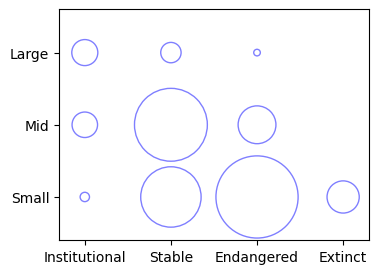

In [28]:
# Draw the empty bubble baseline

plotBubbleGraph(None)

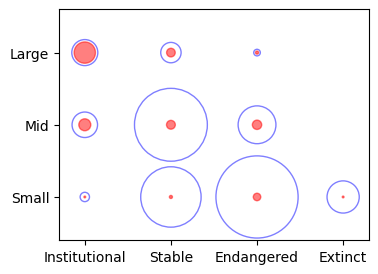

In [29]:
plotBubbleGraph('Size of Wikipedia (Articles Column)')

In [30]:
# This was only considering Abstracts and titles. So it was later replaced by the Blasi-Rohatgi version shown in a block below

# plotBubbleGraph('ACL count')

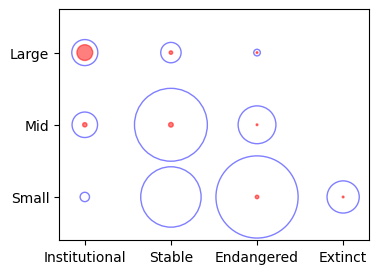

In [31]:
plotBubbleGraph('LDC')

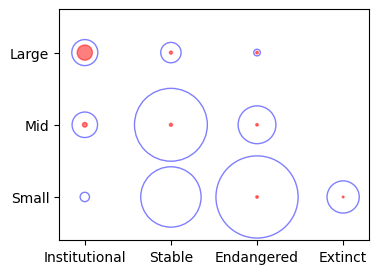

In [32]:
plotBubbleGraph('ELRA')

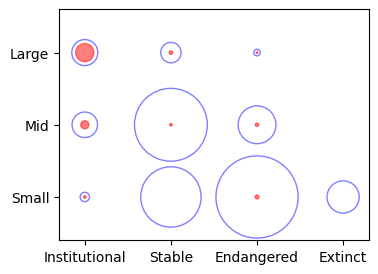

In [33]:
plotBubbleGraph('CC Size')

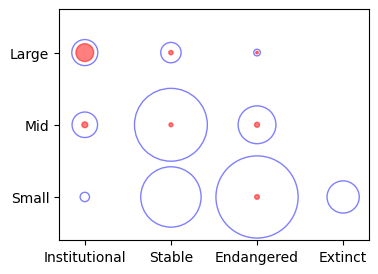

In [34]:
plotBubbleGraph('Is in Facebook')

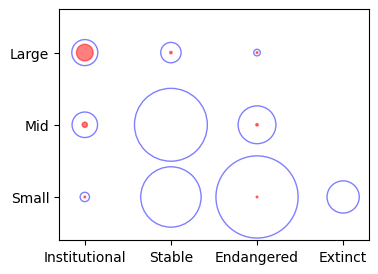

In [35]:
plotBubbleGraph('Is in Google')

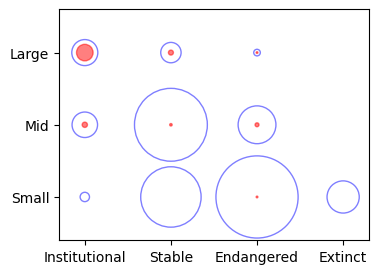

In [36]:
plotBubbleGraph('XLMR+mBERT')

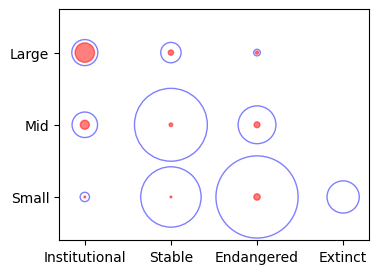

In [37]:
plotBubbleGraph('Hugginface')

# Draw Boxplots
* Figure 3: Boxplots showing the resources where the amounts corresponding to the Ethnologue language classes are countable. (As opposed to Boolean)

In [38]:
def drawBoxPlot(c,multi):
  plt.figure(figsize=(4, 3), dpi=100)
  boxed={}
  for s in d:
    boxed[s]={}
    for v in d[s]:
      boxed[s][v]=d[s][v][["Name",c]].dropna() # Drop Nan
      boxed[s][v]=boxed[s][v][boxed[s][v][c] != 0]  #Drop zero
      boxed[s][v][c]=[multi*float(b.replace(",","").replace("-","0")) if type(b)==str else b for b in boxed[s][v][c].tolist()]
      boxed[s][v][c]=[math.log(b,10) if b>0 else 0 for b in  boxed[s][v][c]]

  boxFlat={}
  for s in sizeArr:
    for v in vitalityArr:
      boxFlat[s+"-"+v]=boxed[s][v][c]

  fig1, ax1 = plt.subplots()
  boxPlotVals=ax1.boxplot(boxFlat.values())

  outliers={}
  plotIndex=0
  for s in sizeArr:
    outliers[s]={}
    for v in vitalityArr:
      outliers[s][v]=list(set(boxPlotVals["fliers"][plotIndex].get_data()[1]))
      outliers[s][v]=boxed[s][v].loc[boxed[s][v][c].isin(outliers[s][v])].to_dict(orient='index')
      plotIndex=plotIndex+1


  print(outliers)


  tickerIndex=range(len(boxFlat))
  tickerIndex=[i+1 for i in tickerIndex]

  plt.ylabel('Log Value')
  plt.xticks(tickerIndex,boxFlat.keys(), rotation='vertical')

  boxplotFileName=makeFileNameArxivSafe("boxplot_"+c)
  plt.savefig(pathI+boxplotFileName+'.png',bbox_inches='tight', dpi=500)
  with open(pathJ+boxplotFileName+'_Outliers.json', 'w') as f:
    json.dump(outliers, f)


{'Small': {'Extinct': {}, 'Endangered': {1091: {'Name': 'Choctaw', 'Size of Wikipedia (Articles Column)': 0.7781512503836435}, 3087: {'Name': 'Latin', 'Size of Wikipedia (Articles Column)': 5.133957034798473}, 3920: {'Name': 'Muskogee', 'Size of Wikipedia (Articles Column)': 0.0}}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {}, 'Stable': {3843: {'Name': 'Motu', 'Size of Wikipedia (Articles Column)': 0.47712125471966244}}, 'Institutional': {1935: {'Name': 'Herero', 'Size of Wikipedia (Articles Column)': 0.0}, 3536: {'Name': 'Marshallese', 'Size of Wikipedia (Articles Column)': 0.6020599913279623}, 4071: {'Name': 'Ndonga', 'Size of Wikipedia (Articles Column)': 0.9030899869919434}}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {58: {'Name': 'Afar', 'Size of Wikipedia (Articles Column)': 0.0}, 2418: {'Name': 'Kanuri', 'Size of Wikipedia (Articles Column)': 0.0}, 4294: {'Name': 'Nuosu', 'Size of Wikipedia (Articles Column)': 0.477

<Figure size 400x300 with 0 Axes>

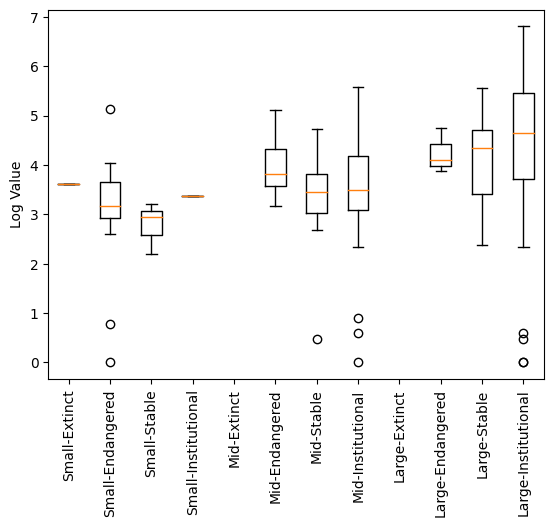

In [39]:
wikiMulti=1
drawBoxPlot('Size of Wikipedia (Articles Column)',wikiMulti)

{'Small': {'Extinct': {}, 'Endangered': {4706: {'Name': 'Prussian', 'LDC': 1.3424226808222062}}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {}, 'Stable': {6294: {'Name': 'Yemba', 'LDC': 0.30102999566398114}}, 'Institutional': {}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {1076: {'Name': 'Chinese', 'LDC': 2.326335860928751}, 1486: {'Name': 'English', 'LDC': 2.7242758696007887}}}}


<Figure size 400x300 with 0 Axes>

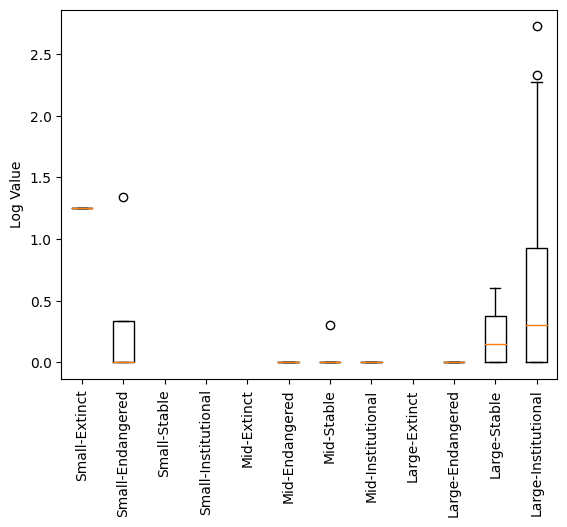

In [40]:
LDCmulti=1
drawBoxPlot('LDC',LDCmulti)

{'Small': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {598: {'Name': 'Basque', 'ELRA': 1.4313637641589871}}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {1486: {'Name': 'English', 'ELRA': 2.9827233876685453}}}}


<Figure size 400x300 with 0 Axes>

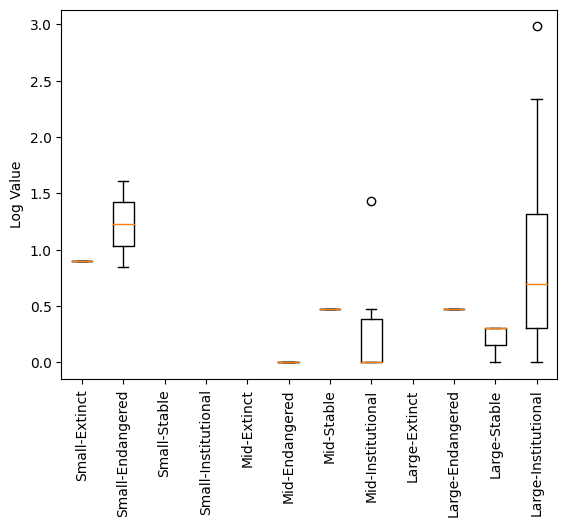

In [41]:
ELRAmulti=1
drawBoxPlot('ELRA',ELRAmulti)

{'Small': {'Extinct': {5067: {'Name': 'Sensi', 'ACL count': 2.1789769472931693}}, 'Endangered': {1422: {'Name': 'E', 'ACL count': 4.4850680742908695}}, 'Stable': {}, 'Institutional': {5854: {'Name': 'Una', 'ACL count': 1.7403626894942439}}}, 'Mid': {'Extinct': {}, 'Endangered': {4565: {'Name': 'Parsi', 'ACL count': 3.402777069610347}, 5723: {'Name': 'Tu', 'ACL count': 2.9334872878487053}, 5802: {'Name': 'U', 'ACL count': 4.162385155857241}}, 'Stable': {153: {'Name': 'Ali', 'ACL count': 3.0523090996473234}, 212: {'Name': 'Anal', 'ACL count': 3.5351674851149437}, 367: {'Name': 'Au', 'ACL count': 3.680154141734373}, 1132: {'Name': 'Col', 'ACL count': 2.9881128402683514}, 1343: {'Name': 'Dom', 'ACL count': 3.2011238972073794}, 1592: {'Name': 'Fur', 'ACL count': 3.077367905284156}, 3294: {'Name': 'Ma', 'ACL count': 3.941908774365599}, 4477: {'Name': 'Pa', 'ACL count': 3.8960850854232842}, 4674: {'Name': 'Pol', 'ACL count': 2.946943270697825}}, 'Institutional': {1691: {'Name': 'Gen', 'ACL co

<Figure size 400x300 with 0 Axes>

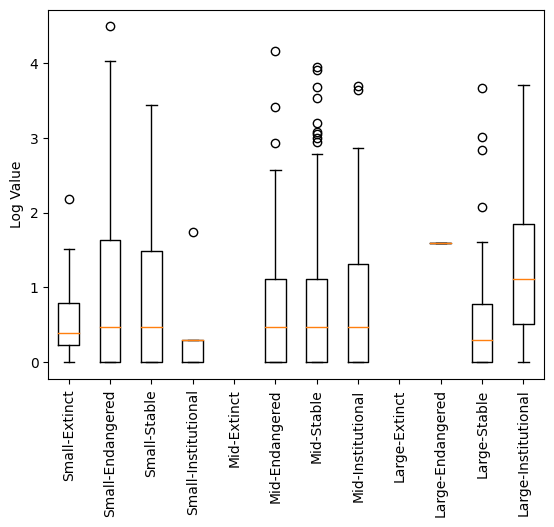

In [42]:
ACLmulti=1
drawBoxPlot('ACL count',ACLmulti)

{'Small': {'Extinct': {}, 'Endangered': {3087: {'Name': 'Latin', 'CC Size': 3.039414119176137}}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {316: {'Name': 'Aromanian', 'CC Size': 3.7868933252613153}}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {}}}


<Figure size 400x300 with 0 Axes>

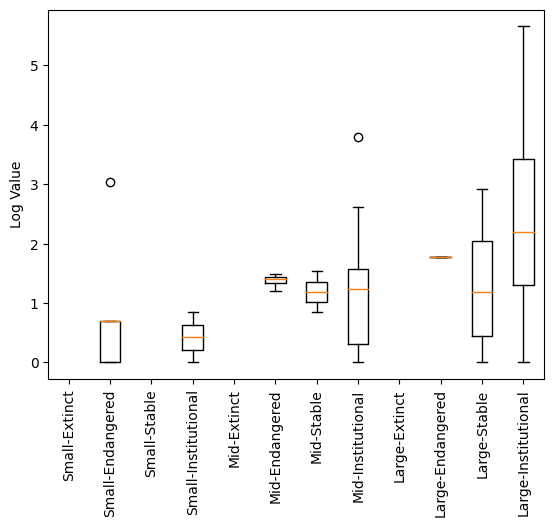

In [43]:
CCmulti=10000
drawBoxPlot('CC Size',CCmulti)

{'Small': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {}, 'Institutional': {}}}


<Figure size 400x300 with 0 Axes>

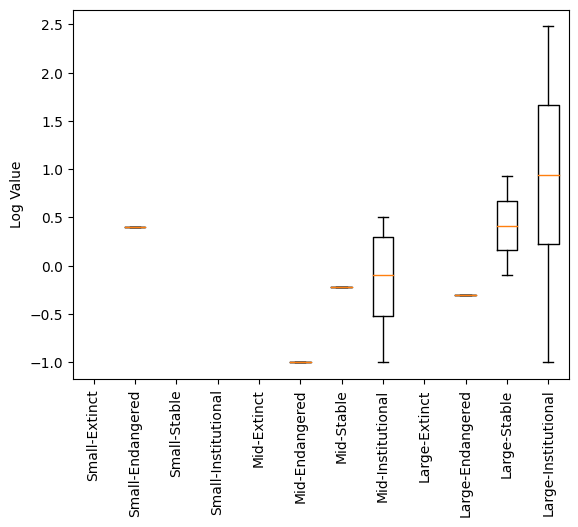

In [44]:
# Note that this is only for XLMR, and not the combined column XLMR+mBert

XLMRmulti=10
drawBoxPlot('Is in XLMR',XLMRmulti)

{'Small': {'Extinct': {}, 'Endangered': {4706: {'Name': 'Prussian', 'Hugginface': 1.8061799739838869}}, 'Stable': {}, 'Institutional': {}}, 'Mid': {'Extinct': {}, 'Endangered': {2482: {'Name': 'Kashubian', 'Hugginface': 0.0}, 4377: {'Name': 'Ojibwa', 'Hugginface': 0.0}}, 'Stable': {}, 'Institutional': {}}, 'Large': {'Extinct': {}, 'Endangered': {}, 'Stable': {421: {'Name': 'Aymara', 'Hugginface': 0.6020599913279623}}, 'Institutional': {391: {'Name': 'Awadhi', 'Hugginface': 0.0}, 1486: {'Name': 'English', 'Hugginface': 2.8457180179666586}, 1942: {'Name': 'Hiligaynon', 'Hugginface': 0.0}, 2418: {'Name': 'Kanuri', 'Hugginface': 0.0}, 6403: {'Name': 'Zhuang', 'Hugginface': 0.0}}}}


<Figure size 400x300 with 0 Axes>

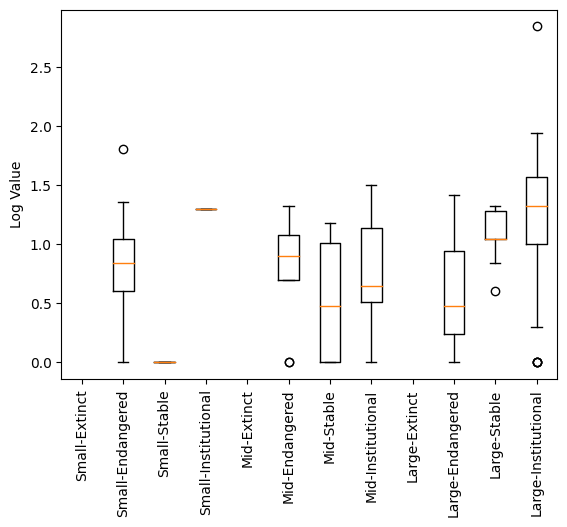

In [45]:
HugginfaceMulti=1
drawBoxPlot('Hugginface',HugginfaceMulti)

# Create the Language Lists to publish (Full list and Ethnologue list)

In [46]:
ourLangsPath=languagesPath+"OurLangs.txt"

f = open(ourLangsPath, "w")

for l,i in zip(ourFullLangList,range(len(ourFullLangList))):
  f.write(l)
  if i< len(ourFullLangList)-1:
    f.write("\n")

f.close()

In [47]:
ethnologuelanguagesPath=languagesPath+"Language_Classes_According_To/Ethnologue/"

if(not os.path.exists(ethnologuelanguagesPath)):
  os.makedirs(ethnologuelanguagesPath)

latexString="\\tiny\n"
langNames={}
for s in d:
  langNames[s]={}
  for v in d[s]:
    langNames[s][v]=d[s][v][["Name"]].values.tolist()
    langNames[s][v]= [x for xs in langNames[s][v] for x in xs]
    if(len(langNames[s][v])>0):
      ethnologueClass=s+" - "+v
      latexString=latexString+"\\underline{\\textbf{"+ethnologueClass+"}}\n"
      ethnologueClass=ethnologueClass.replace(" ","")
      f = open(ethnologuelanguagesPath+ethnologueClass+".txt", "w")
      latexString=latexString+"\\begin{multicols}{6}\n"
      for l,i in zip(langNames[s][v],range(len(langNames[s][v]))):
        latexString=latexString+l+"\\\\\n"
        f.write(l)
        if i< len(langNames[s][v])-1:
          f.write("\n")
      latexString=latexString+"\n\\end{multicols}"
      f.close()

latexString

'\\tiny\n\\underline{\\textbf{Small - Extinct}}\n\\begin{multicols}{6}\nA-Pucikwar\\\\\nAcroá\\\\\nAdithinngithigh\\\\\nAgavotaguerra\\\\\nAghu-Tharnggala\\\\\nAguano\\\\\nAi-Cham\\\\\nAjawa\\\\\nAka-Bea\\\\\nAka-Bo\\\\\nAka-Cari\\\\\nAka-Kede\\\\\nAka-Kol\\\\\nAka-Kora\\\\\nAkar-Bale\\\\\nAlgonquin\\\\\nAlngith\\\\\nAndoa\\\\\nAnserma\\\\\nAore\\\\\nArakwal\\\\\nArarandewára\\\\\nAreba\\\\\nAribwatsa\\\\\nArikem\\\\\nAtampaya\\\\\nAurá\\\\\nAushiri\\\\\nAwishira\\\\\nAwngthim\\\\\nAyabadhu\\\\\nAyerrerenge\\\\\nBadjiri\\\\\nBaga Kaloum\\\\\nBaga Sobané\\\\\nBaldemu\\\\\nBaniva\\\\\nBarababaraba\\\\\nBarbaram\\\\\nBarrow Point\\\\\nBasa-Gumna\\\\\nBasay\\\\\nBayali\\\\\nBerakou\\\\\nBerbice Dutch Creole\\\\\nBerti\\\\\nBibbulman\\\\\nBidjara\\\\\nBigambal\\\\\nBikya\\\\\nBindal\\\\\nBirked\\\\\nBirrpayi\\\\\nBishuo\\\\\nBung\\\\\nBurduna\\\\\nBusuu\\\\\nCacaopera\\\\\nCahuarano\\\\\nCaramanta\\\\\nCentúúm\\\\\nChagatai\\\\\nChimariko\\\\\nCholón\\\\\nCoquille\\\\\nCuitlatec\\\\\nDagoma

# Draw Cumulative charts
* Figure 17: ACL Abstract Participation of the languages belonging to the 12 Ethnologue language classes

## Generate the intermediate files

In [48]:
urlPath=intermediatePath+"ACL_URLs.txt"

f = open(aclBibPath, "r", encoding="utf-8")
g = open(urlPath, "w")

title=""

for x in f:
  if("booktitle" not in x)and("title =" in x or "Title =" in x):
    title=x[x.index("\"")+1:x.rindex("\"")]
    if(len(title)==0):
      title=x[x.index("{")+1:x.rindex("}")]
  elif("url =" in x):
    x=x[x.index("\"")+1:x.rindex("\"")]
    x=title+"\t"+x+"\n"
    g.write(x)
    title=""

f.close()
g.close()

In [49]:
f = open(aclBibPath, "r", encoding="utf-8")
titleList={}
candidateYears=[2010,2015,2020]

for x in f:
  if("booktitle" not in x)and("title =" in x or "Title =" in x):
    title=x[x.index("\"")+1:x.rindex("\"")]
    if(len(title)==0):
      title=x[x.index("{")+1:x.rindex("}")]
  if("year =" in x or "Year =" in x):
    year=x[x.index("\"")+1:x.rindex("\"")]
    if(len(year)==0):
      year=year[year.index("{")+1:year.rindex("}")]
    if(int(year) in candidateYears):
      if(year in titleList):
        titleList[year].append(title)
      else:
        titleList[year]=[title]

In [50]:
# Sample random titles for manual inspection

for y in titleList:
  titleList200=random.sample(titleList[y], 200)
  g = open(pathA+y+"_200Titles.txt", "w")
  for t in titleList200:
    g.write(t+"\n")
  g.close()

In [51]:
urlPath=intermediatePath+"ACL_URLs.txt"

# The following files take many hours to generate. So, for re-running, we have saved them in intermediate outputs.
# But if you wish to generate these outputs anew, you need to delete **all three** of these files before proceeding
abstractPath=intermediatePath+"ACL_Abstracts.txt"
pubStatsFileName=intermediatePath+'pubStatsFile.pkl'
allpaperCountsFileName=intermediatePath+'allpaperCounts.pkl'


In [52]:
# Process ACL web page

def processPage(x):
  x=x.split("\t")
  title=x[0]
  x=x[1]
  h=requests.get(x.strip()+"/")
  h=h.text
  soup = BeautifulSoup(h, 'html.parser')  # Parse the html file
  try:
    abstract = soup.find_all("div", {"class": "acl-abstract"})[0].span.string
    if(abstract==None):
      h=h.split("\n")
      for l in h:
        if "abstract =" in l:
          l=l.split("&#34;")
          abstract =l[1]
  except:
    abstract =""
  return title,abstract

In [53]:
if (os.path.isfile(abstractPath) and os.path.isfile(pubStatsFileName) and os.path.isfile(allpaperCountsFileName)):
  print("ACL abstracts have already been downloaded. We are skipping this step.")
  print("If you want to re-download, delete ACL_Abstracts.txt, pubStatsFile.pkl, allpaperCounts.pkl and run this block again.")
else:
  f = open(urlPath, "r", encoding="utf-8")
  g = open(abstractPath, "w")
  k = open(abstractPath, "r", encoding="utf-8")

  abstractList=[]

  for l in k:
    l="\t".join(l.split("\t")[:2]).strip()
    abstractList.append(l)

  abstractList=set(abstractList)

  lines=[]

  for l in f:
    l=l.strip()
    if l not in abstractList:
      lines.append(l)

  i=0
  for x in tqdm(lines):
    title,abstract=processPage(x)
    if(i==0):
      g = open(abstractPath, "w")
    elif(i%1000==0):
        g.close()
        g = open(abstractPath, "a")
    i=i+1
    try:
      g.write(x.strip()+"\t"+abstract+"\n")
    except:
      print(x.strip())
      continue

  g.close()

ACL abstracts have already been downloaded. We are skipping this step.
If you want to re-download, delete ACL_Abstracts.txt, pubStatsFile.pkl, allpaperCounts.pkl and run this block again.


## Generate the Charts

In [54]:
langList=inputPath+"ethnologueLanguagesList.txt"

In [55]:
p = inflect.engine()

conf=["first",'second','third','fourth','fifth','sixth',"seventh","eighth","ninth","tenth","eleventh","twelfth","thirteenth","fourteenth","fifteenth","sixteenth","seventeenth","eighteenth","nineteenth","twentieth"]

capital=[c.title() for c in conf]

conf=conf+capital

mainVenues=[]

for i in range(70):
    conf.append(p.ordinal(i+1))

conf=[" "+c+" " for c in conf]

f=open(aclBibPath, "r", encoding="utf-8")

def simplyfyVenue(x):
  for c in conf:
    if c in x:
      x=x.split(c)[1]
      break
  x=x.split("(")[0].strip()
  for i in range(1900,2021):
    if str(i) in x:
      x=x.split(str(i))[1].strip()
  return(x)

mainVenues=["Main Conference",
            "Annual Meeting of the Association for Computational Linguistics",
            "North American Chapter of the Association for Computational Linguistics",
            "{E}uropean Chapter of the Association for Computational Linguistics",
            "Empirical Methods in Natural Language Processing",
            "International Conference on Computational Linguistics",
            "Conference on Computational Natural Language Learning",
            "International Workshop on Semantic Evaluation",
            "Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics",
            "Conference on Computational Natural Language Learning"]

def mapVanue(x,isJournal):
  if ("Language Resources and Evaluation" in x) or ("LREC" in x):
    return("LREC")
  elif any([v in x for v in mainVenues]):
    mainVenues.append(x)
    return("Main")
  elif isJournal and (("Transactions of the Association for Computational Linguistics" in x) or ("Computational Linguistics" in x)):
    return("Journal")
  else:
    return("Other")

def defang(x):
  s=x[x.index("\"")+1:x.rindex("\"")]
  if(len(s)==0):
    s=x[x.index("{")+1:x.rindex("}")]
  return(s)

paperDetails={}
counter=0

for x in f:
  if("booktitle" not in x)and("title =" in x or "Title =" in x):
    title=defang(x)
    counter=1
  elif("booktitle" in x):
    place=defang(x)
    place=mapVanue(place,False)
    counter=counter+1
  elif ("journal =" in x):
    place=defang(x)
    place=mapVanue(place,True)
    counter=counter+1
  elif("year =" in x):
    year=int(defang(x))
    counter=counter+1
  if(counter==3):
    paperDetails[title]=[place,year]
    counter=0

mainVenues=list(set(mainVenues))

In [56]:
fileLines=[]

def readFile():
  if len(fileLines)==0:
    f=open(abstractPath, "r", encoding="utf-8")
    for l in f:
      fileLines.append(l)


def processLang(s):
	u=s.title()
	b=s.title()
	for c in b:
		if c.isupper():
			b=b.replace(c, "{"+c+"}", 1)
	return [s,u,b]

def listToQueryWords(k):
  queryWords={}
  for lang in k:
    lang=lang.split("(")
    lang[-1]=lang[-1].replace(")","")
    lang=[l.strip() for l in lang]
    langExpanded=[]
    for l in lang:
      langExpanded=langExpanded+processLang(l)
    queryWords[lang[0]]=langExpanded
  return queryWords

def getStatsForLangList(langList):
  totalCount=0
  queryWords=listToQueryWords(langList)
  yearConfCount={}
  allPapers=[]
  readFile()

  for l in tqdm(fileLines):
    l=l.split("\t")
    totalCount=totalCount+1
    linePassed=False
    for lang in queryWords:
      if(any([q in l[0] for q in queryWords[lang]])):
        linePassed=True
      if(len(l)>2):
        if(any([q in l[2] for q in queryWords[lang]])):
          linePassed=True
      if(linePassed and l[0] in paperDetails):
        details=paperDetails[l[0]]
        if details[1] not in yearConfCount:
          yearConfCount[details[1]]={}
        if details[0] not in yearConfCount[details[1]]:
          yearConfCount[details[1]][details[0]]=[]
        yearConfCount[details[1]][details[0]].append(l[0])

  for y in yearConfCount:
    for p in yearConfCount[y]:
      allPapers=list(set(allPapers+yearConfCount[y][p]))
      yearConfCount[y][p]=len(set(yearConfCount[y][p]))

  return(yearConfCount,len(allPapers))

In [57]:
# Print a sample of the data for a set of languages

getStatsForLangList(["sinhala","Tamil"])

100%|██████████| 70081/70081 [00:00<00:00, 154800.64it/s]


({2021: {'Other': 73, 'Main': 6},
  2020: {'Other': 24, 'LREC': 6, 'Main': 4},
  2019: {'Other': 12, 'Main': 3},
  2018: {'Other': 4, 'LREC': 2, 'Main': 2},
  2017: {'Other': 3, 'Journal': 1},
  2016: {'Other': 8},
  2015: {'Other': 3},
  2014: {'Other': 3},
  2012: {'Other': 5, 'LREC': 1},
  2011: {'Other': 1},
  2010: {'Other': 1},
  2009: {'Other': 4},
  2008: {'Other': 3},
  2006: {'Main': 1},
  2005: {'Other': 1}},
 171)

In [58]:
# This calculation takes several hours. So we have serialized the data in the Intermediate Outputs folder.
pubStats={}
allpaperCounts={}


if(os.path.isfile(pubStatsFileName) and os.path.isfile(allpaperCountsFileName)):
  with open(pubStatsFileName, 'rb') as pubStatsFile:
    pubStats = pickle.load(pubStatsFile)

  with open(allpaperCountsFileName, 'rb') as allpaperCountsFile:
    allpaperCounts = pickle.load(allpaperCountsFile)
else:
  for s in d:
    if s not in pubStats:
      pubStats[s]={}
      allpaperCounts[s]={}
    for v in d[s]:
      langList=d[s][v]["Name"].tolist()
      print(s+" "+v+" : "+str(len(langList)))
      pubStats[s][v],allpaperCounts[s][v]=getStatsForLangList(langList)

    with open(pubStatsFileName, 'wb') as pubStatsFile:
      pickle.dump(pubStats, pubStatsFile)

    with open(allpaperCountsFileName, 'wb') as allpaperCountsFile:
      pickle.dump(allpaperCounts, allpaperCountsFile)

In [59]:
# Calculate the edges

minN=9999
maxN=0

for s in pubStats:
  for v in pubStats[s]:
    years=list(pubStats[s][v].keys())
    years.sort()
    if len(years)>0:
      if years[0]<minN:
        minN=years[0]
      if years[-1]>maxN:
        maxN=years[-1]

In [60]:
def plotCumulativeGraph(s,v,col,drawLegend):
  plt.figure(figsize=(4, 3), dpi=100)
  years=list(pubStats[s][v].keys())
  years.sort()

  if(len(years)==0):
    return("No need to generate an empty graph")

  years=range(years[0],years[-2])  # This drops the current year. It is by design because that year is incomplete

  classes=["Other","Main","LREC","Journal"]

  x_String="Years"
  y_string="Paper Count"+"_Cumulative"
  outputFileName="ACL_"+s+"_"+v+"_Cumulative"

  stats=pubStats[s][v]


  result=list(range(len(classes)))

  for cla,c in zip(classes,range(len(classes))):
    result[c]=list(range(len(years)))
    for year,y in zip(years,range(len(years))):
      if year in stats and cla in stats[year]:
        result[c][y]=stats[year][cla]
      else:
        result[c][y]=0

  # Apply Cumulative
  for c in range(len(result)):
    sum=0
    for y in range(len(result[c])):
      sum=sum+result[c][y]
      result[c][y]=sum

  # Apply Percentage
  for y in range(len(result[c])):
    sum=0
    for c in range(len(result)):
      sum=sum+result[c][y]
    for c in range(len(result)):
      result[c][y]=(100*result[c][y])/sum


  if(col is None):
    plt.stackplot(years,result, labels=classes)
  else:
    plt.stackplot(years,result, labels=classes,colors = col)

  if(drawLegend):
    legend =plt.legend(loc="upper left",  bbox_to_anchor=(1, 1), ncol=len(classes))  #New internal
    outputFileName="Axis_ACL"

  plt.xticks(rotation=90)
  plt.xlabel(x_String)
  plt.ylabel(y_string)

  outputFileName=makeFileNameArxivSafe(outputFileName)
  plt.savefig(pathI+outputFileName+'.png',bbox_inches='tight', dpi=500)


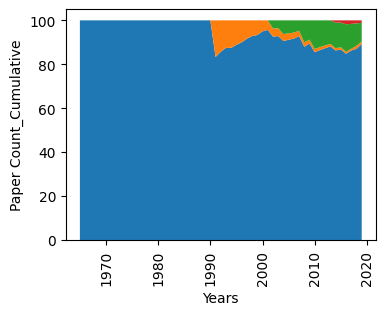

In [61]:
col=None #Colours

plotCumulativeGraph(sizeArr[0],vitalityArr[0],col,False)

1575 1928


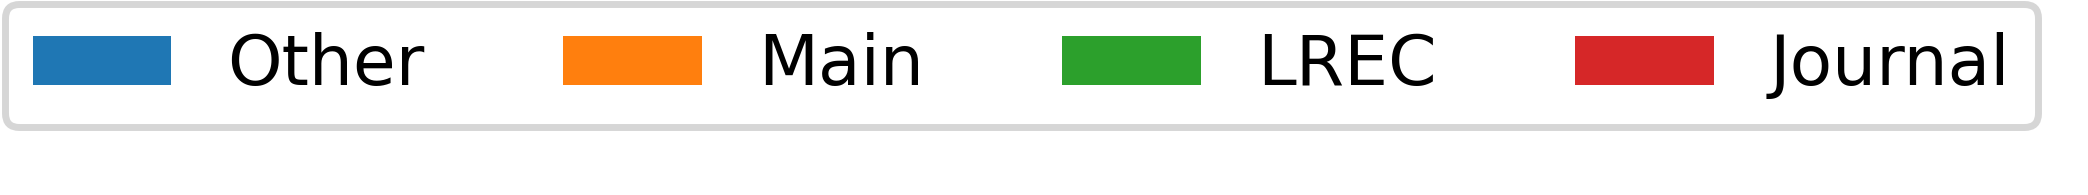

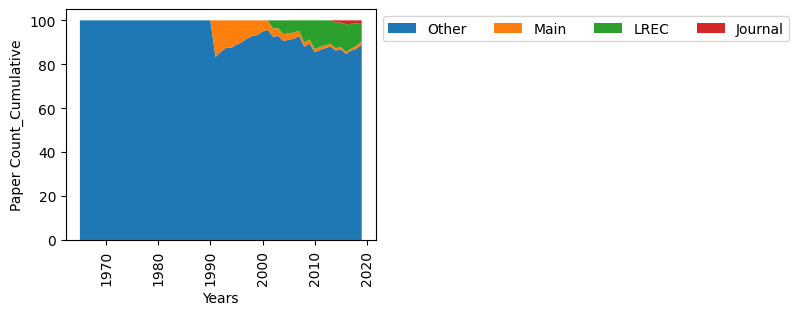

In [62]:
plotCumulativeGraph(sizeArr[0],vitalityArr[0],col,True)
cropAxis("ACL_Small_Extinct_Cumulative","Axis_ACL",80,1300,20)

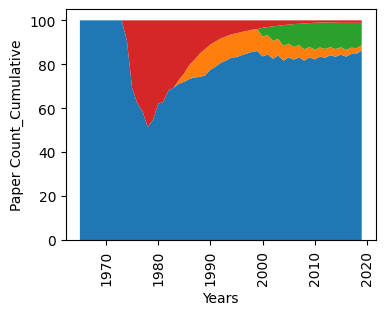

In [63]:
plotCumulativeGraph(sizeArr[0],vitalityArr[1],col,False)

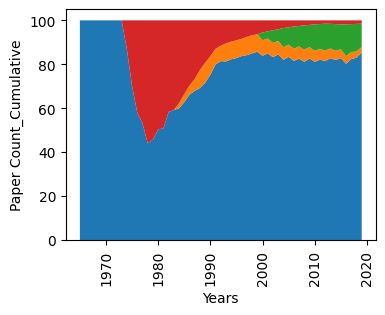

In [64]:
plotCumulativeGraph(sizeArr[0],vitalityArr[2],col,False)

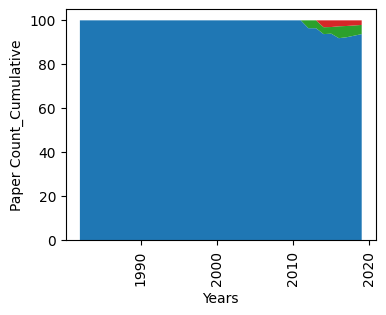

In [65]:
plotCumulativeGraph(sizeArr[0],vitalityArr[3],col,False)

In [66]:
plotCumulativeGraph(sizeArr[1],vitalityArr[0],col,False)

'No need to generate an empty graph'

<Figure size 400x300 with 0 Axes>

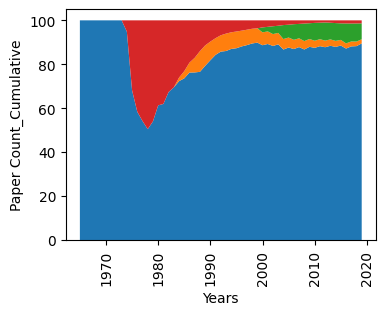

In [67]:
plotCumulativeGraph(sizeArr[1],vitalityArr[1],col,False)

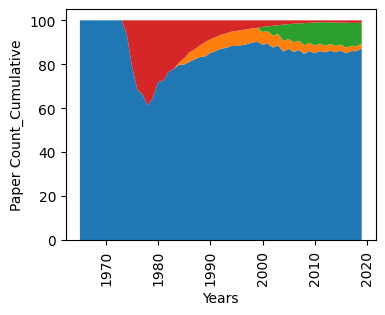

In [68]:
plotCumulativeGraph(sizeArr[1],vitalityArr[2],col,False)

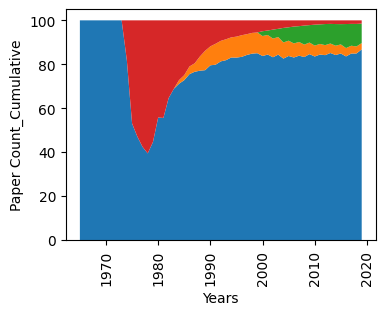

In [69]:
plotCumulativeGraph(sizeArr[1],vitalityArr[3],col,False)

In [70]:
plotCumulativeGraph(sizeArr[2],vitalityArr[0],col,False)

'No need to generate an empty graph'

<Figure size 400x300 with 0 Axes>

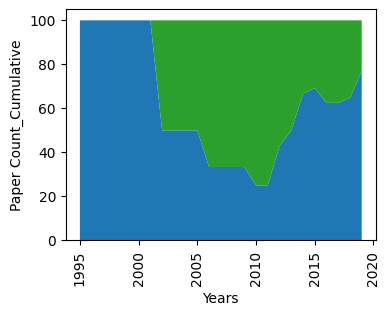

In [71]:
plotCumulativeGraph(sizeArr[2],vitalityArr[1],col,False)

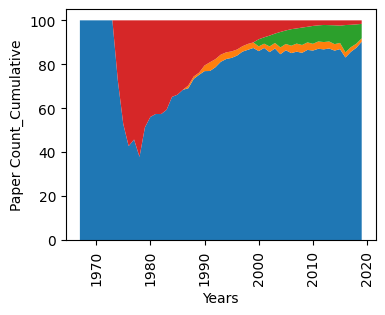

In [72]:
plotCumulativeGraph(sizeArr[2],vitalityArr[2],col,False)

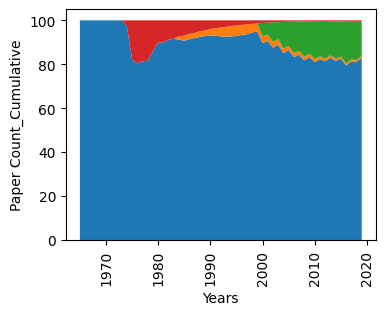

In [73]:
plotCumulativeGraph(sizeArr[2],vitalityArr[3],col,False)

# Reconstructing Joshi et al. (2020) language classes

* Figure 5: Reconstructing Joshi et al. (2020) language classes with Wikipedia article count as the unannotated source and two configurations of annotated sources.
* Table 8: Confusion Matrix of Joshi et al. (2020) classes and Ethnologue language classes considering only LDC and ELRA as the annotated sources, where Ex=Extinct, En=Endangered, St=Stable, and In=Institutional.
* Table 9: Confusion Matrix of Joshi et al. (2020) classes and Ethnologue language classes considering Huggingface, LDC, and ELRA as the annotated sources, where Ex=Extinct, En=Endangered, St=Stable,and In=Institutional.


In [74]:
# Setup initial Joshi regions

joshiMap={-1:'white',0:'green',1:'blue',2:'purple',3:'orange',4:'red'}
oldJoshiMap={-1:'white',0:'green',1:'blue',2:'purple',3:'yellow',4:'orange',5:'red'}

def getClass(x,y,c):
  if float(c)<=0:
    return -1 # 'white'

  if x<=2:
    return 0 #'green'
  elif x>=5.9 and y>2.0:
    return 4 #'red'
  elif x>=5 and y>=1.5:
    return 3 #'orange'
  elif x>=4.2 and y>=1.0:
    return 2 #'purple'
  else:
    return 1 #'blue'

In [75]:
# Create a new data frame with the derived class columns

classes12=[]
for s in sizeArr:
  for v in vitalityArr:
    classes12.append(s+"-"+v)

supervised=''
unsupervised=''


def buildFrame(supevisedColumns,supMulti,unsupervisedCoulmns,unsupMulti):
  global supervised
  global unsupervised

  df=data.fillna(0) # Get rid of NaNs

  df[unsupervisedCoulmns[0]]=[float(b.replace(",","").replace("-","0")) if type(b)==str else b for b in df[unsupervisedCoulmns[0]].tolist()]  # Drop commas of Wikipedia

  # Now  convert Strings to numbers
  for col in supevisedColumns+unsupervisedCoulmns:
    df[col]=pd.to_numeric(df[col],errors='coerce')


  # Now the strings have become NaNs. They too have to be removed
  df=df.fillna(0) # Get rid of NaNs

  for col,mult in zip(supevisedColumns+unsupervisedCoulmns,supMulti+unsupMulti):
    df[col]=mult*df[col]

  supervised='supevised'
  unsupervised=unsupervisedCoulmns[0]

  # Get the average of 'supevisedColumns' to a new column
  df[supervised] = df[supevisedColumns].sum(axis=1)

  #Take log
  for col in [supervised,unsupervised]:
    df[col]=[math.log(b,10)+1 if b>0 else 0 for b in  df[col]]

  # Create class labels
  df['Label']=df['ethnolog_Size']+"-"+df['ethnolog_Vitality']

  df["12class"]=[classes12.index(l) for l in df["Label"]]

  df['NewJoshiClass']=[getClass(x,y,1) for x,y in zip(df[unsupervised].tolist(),df[supervised].tolist())]

  return(df)

In [76]:
def printLatexTable(df):
  printdf = pd.DataFrame([])

  tableRows='Joshi Classes Smooth'
  sumN=0
  for i in range(len(classes12)):
    printdf[classes12[i]]=[len(df[(df['12class'] == i) & (df[tableRows]==j)]) for j in range(len(set(df[tableRows])))]
    sumN=sumN+printdf[classes12[i]].sum()

  # Now create the sum row and sum column
  printdf['Sum'] = printdf.sum(axis=1) #Rows
  printdf.loc['Total']= printdf.sum()  #Colums

  lines=printdf.to_latex()

  lines=lines.replace(".0 &"," &")
  lines=lines.split("\midrule")[1]
  lines=lines.split("\\bottomrule")[0]
  while "&  " in lines:
    lines=lines.replace("&  ","& ")
  while "  &" in lines:
    lines=lines.replace("  &"," &")
  lines=lines.replace("Total","\hline\nTotal")
  return(lines,sumN)

In [77]:
from matplotlib import pyplot

huggingSuffix="" # This will be set later
classAreas={} # This too will be set later

def drawWithClass(df,cln,areaM,oldJoshi,withLegend,huggingSuffix):
  global classAreas
  fig, ax = plt.subplots(figsize=(2, 1), dpi=100)

  if oldJoshi:
    JoshiClasses=[ oldJoshiMap[j] for j in df['Joshi Classes Smooth']]
  else:
    if len(cln)>0:
      JoshiClasses=[joshiMap[getClass(x,y,c)] for x,y,c in zip(df[unsupervised].tolist(),df[supervised].tolist(),df[cln].tolist())]
    else:
      JoshiClasses=[joshiMap[getClass(x,y,1)] for x,y in zip(df[unsupervised].tolist(),df[supervised].tolist())]

  if(areaM):
    colN=1
  else:
    colN=len(jcolourNames)

  scatter = ax.scatter(df[unsupervised].tolist(), df[supervised].tolist() ,c=df["Joshi Classes Smooth"].tolist() ,s=20, alpha=0.5,cmap=jcmp, edgecolor='black')  #c=JoshiClasses  s=1, c=colors,  c=df["12class"].tolist()  ,marker="^",s=50   # c=NewJoshiClasses

  if(withLegend):
    legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="Classes", bbox_to_anchor=(1, 1), ncol=colN)
    ax.add_artist(legend1)


  if(areaM):
    for i in classAreas:
      print("Shading: "+str(i))
      ax.fill(classAreas[i][0], classAreas[i][1], alpha=0.3, c=jcolourNames[i])

  ax.grid()
  plt.xlabel("Unlabeled data (log)")
  plt.ylabel("Labeled data (log)")

  xLim=8
  yLim=4
  plt.xticks(range(xLim+1),['']+['$10^'+str(i)+'$' for i in range(xLim)])
  plt.yticks(range(yLim+1),['']+['$10^'+str(i)+'$' for i in range(yLim)])

  plt.xlim([0, xLim+0.5])
  plt.ylim([0, yLim+0.5])

  if len(cln)>0:
    fileName='classes_'+cln+'_'+huggingSuffix
  else:
    fileName='classes_'+huggingSuffix

  if areaM:
    fileName=fileName+'_AreaMarked.png'
  elif withLegend: # This is the legend-only option
    fileName=pathI+"Axis_Joshi.png"
  else:
    fileName=fileName+'.png'

  fig.set_size_inches(8, 4)
  fileName=makeFileNameArxivSafe(fileName)
  fileName=pathI+fileName
  print(fileName)
  plt.savefig(fileName,bbox_inches='tight', dpi=500)

In [79]:
# Preprare the Data frame df
knnX=['Size of Wikipedia (Articles Column)','supevised']
knnY='Joshi Classes'



def initiateKnn(df):
  knn = KNeighborsClassifier(n_neighbors=5) # Create the knn model. # Look at the five closest neighbours.

  df[knnY]=[int(j) for j in df[knnY].tolist()]

  knnTrain=df[df[knnY]!=-1]

  knn.fit(knnTrain[knnX], knnTrain[[knnY]]) # Fit the model on the training data.

  predictions= knn.predict(df[knnX]) # Make point predictions on the test set using the fit mod

  df[knnY]=[ p  if j<0 else j  for j,p in zip(df[knnY].tolist(),predictions)] # Now update
  return(df)

In [80]:
# Now let's create the smoothed column

knnYnew='Joshi Classes Smooth'

def smoothen(df,inCol,outCol,precedence,k):
  knn = KNeighborsClassifier(n_neighbors=k)

  knn.fit(df[knnX], df[[inCol]]) # Fit the model on the training data.

  if(precedence):
    predictions= knn.predict(df[knnX]) # Make point predictions on the test set using the fit mod
    df[outCol]=[ n if n>o else o for o,n in zip(df[outCol].tolist(),predictions)]
  else:
    df[outCol]= knn.predict(df[knnX]) # Make point predictions on the test set using the fit mod
  return(df)

In [81]:
# Construct the convex hulls and assign points

xCol='Size of Wikipedia (Articles Column)'
yCol='supevised'

def in_hull(p, Xlist,yList):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    hull=[ [x,y]  for x,y in zip(Xlist,yList)]
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def generateClassRegions(df,inte):
  global classAreas
  joshiClassList=list(set(df[knnYnew]))
  joshiClassList.sort()
  for i in joshiClassList:
    points=df[df[knnYnew]==i][[xCol,yCol]].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],points[hull.vertices,1][0])

    if(inte):
      dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
      dist_along = np.concatenate(([0], dist.cumsum()))
      spline, u = interpolate.splprep([x_hull, y_hull],u=dist_along, s=0)
      interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
      interp_x, interp_y = interpolate.splev(interp_d, spline)
      classAreas[i]=[interp_x, interp_y] #[x_hull,y_hull]
    else:
      classAreas[i]=[x_hull,y_hull]

def reassignpoints(df,withPrecedence):
  global classAreas
  joshiClassList=list(set(df[knnYnew]))
  joshiClassList.sort()
  joshiClassList.reverse()
  reassignedCount=0
  for i in joshiClassList:
    if(withPrecedence):
      points=df[df[knnYnew]<i][[xCol,yCol]].values # Only smaller classes get overwhelmed by the bigger ones
    else:
      points=df[df[knnYnew]!=i][[xCol,yCol]].values # All violating points corrected, higher and lower (Warning: This should only happen after all other corrections are done.)
    for p in points:
      if(in_hull(p, classAreas[i][0],classAreas[i][1])):
        row=df.index[(df[xCol]==p[0]) & (df[yCol]==p[1])].tolist()[0]
        df.loc[row,knnYnew] = i
        reassignedCount=reassignedCount+1
  return(df,reassignedCount)

# This restores the class 0 and 1 boarders that are axis parallel
def restoreAxisPrallelJoshiBoarders(df):
  # Everthing left to 10^1 line should be class 0
  rows=df.index[(df[xCol]<2.1)&(df[knnYnew]>0)].tolist()
  for r in rows:
    df.loc[r,knnYnew] = 0

  # Class 1 should not go above 10^1
  rows=df.index[(df[yCol]>1.0)&(df[knnYnew]==1)].tolist()
  for r in rows:
    df.loc[r,knnYnew] = 2

  return(df)

In [82]:
def drawWithSmoothen(withHuggingFace,area,withLegend,epochCount,useNewestHugginFace):
  if(withHuggingFace):
    huggingSuffix="with_HuggingFace"
    hugginfceCol='Hugginface'
    if(useNewestHugginFace):
      hugginfceCol='HF new'
    df=buildFrame(['LDC',	'ELRA',hugginfceCol],[LDCmulti,ELRAmulti,1],['Size of Wikipedia (Articles Column)'],[wikiMulti])  # With Huggingface
  else:
    huggingSuffix="without_HuggingFace"
    df=buildFrame(['LDC',	'ELRA'],[LDCmulti,ELRAmulti],['Size of Wikipedia (Articles Column)'],[wikiMulti])  # Without Huggingface
  df=initiateKnn(df)

  df=smoothen(df,knnY,knnYnew,False,5) # The first iteration is from actual to new

  reassignedCount=epochCount

  while reassignedCount>0:
    df=smoothen(df,knnYnew,knnYnew,True,107) #  Subsequent iterations are from new to new  #57
    if(not withHuggingFace):
      generateClassRegions(df,False) # Generate for original assignment without curves
    df,reassignedCount=reassignpoints(df,True) # Now reassign
    generateClassRegions(df,False) #re-Generate for new assignment without curves

  # Restore class 0 and 1 Joshi borders
  df=restoreAxisPrallelJoshiBoarders(df)
  generateClassRegions(df,False) #re-Generate for new assignment without curves

  df,reassignedCount=reassignpoints(df,False) # Now reassign one last time without precedence
  generateClassRegions(df,False) #Generate for final assignment without curves
  print("*********************************************")
  drawWithClass(df,'',area,True,withLegend,huggingSuffix)
  return(df)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

*********************************************
Shading: 0
Shading: 1
Shading: 2
Shading: 3
Shading: 4
Shading: 5
/content/gdrive/MyDrive/Research/AACL Sinhala Paper/Final Official Github Repo/Data/Output/images/classes_without_HuggingFace_AreaMarked.png


<ipython-input-76-7655fb4679d0>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=printdf.to_latex()


6420

0 & 331 & 2146 & 1165 & 27 & 0 & 430 & 1676 & 165 & 0 & 11 & 109 & 75 & 6135 \\
1 & 1 & 15 & 3 & 1 & 0 & 28 & 24 & 40 & 0 & 2 & 22 & 73 & 209 \\
2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 1 & 0 & 19 & 22 \\
3 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 26 & 29 \\
4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 17 & 18 \\
5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 7 & 7 \\
\hline
Total & 332 & 2162 & 1168 & 28 & 0 & 458 & 1700 & 208 & 0 & 14 & 133 & 217 & 6420 \\



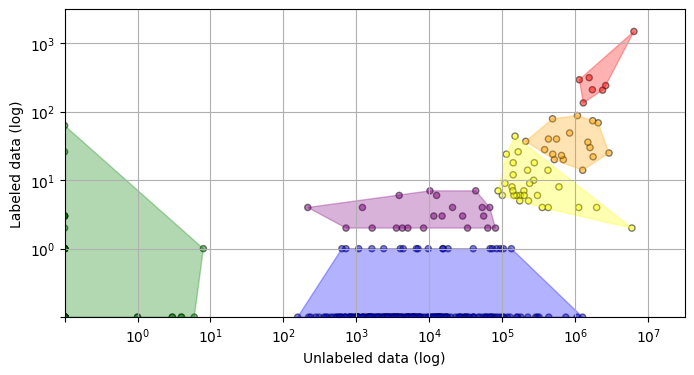

In [83]:
# Draw without Huggingface and area marked

df=drawWithSmoothen(False,True,False,1,False)
lines,allLangCount=printLatexTable(df)

print(allLangCount)
print(lines)

f=open(pathT+"withoutHugging.tex",'w')
f.write(lines)
f.close()

In [84]:
# View the languages in the top class

df[df[knnYnew]==5]

,Name,ethnolog_Size,ethnolog_Vitality,L1 speakers,L2 speakers,New wiki,Size of Wikipedia (Articles Column),language family,geographical location,geo location analysis,...,Is in Facebook,Joshi Classes,mBERT,HF new,XLMR+mBERT,supevised,Label,12class,NewJoshiClass,Joshi Classes Smooth
279,Arabic,Large,Institutional,350 million,270 million,1174540.0,7.056796,Afro-Asiatic,0,Central Asia,...,1,5,1.0,83.0,29.0,3.468347,Large-Institutional,11,4,5
1076,Chinese,Large,Institutional,1.2 billion,0,1458327.0,7.192012,Sino-Tibetan,"China, Singapore, Taiwan\nCantonese, Hong K...",Eastern Asia,...,1,5,1.0,72.0,1.0,3.498311,Large-Institutional,11,4,5
1486,English,Large,Institutional,360–400 million,750 million,6538164.0,7.805702,Indo-European,"Europe, North America, Australia",Western Europe,...,1,5,1.0,625.0,301.8,4.173478,Large-Institutional,11,4,5
1582,French,Large,Institutional,76.8 million,197 million,2437710.0,7.375905,Indo-European,France,Western Europe,...,1,5,1.0,101.0,57.8,3.315970,Large-Institutional,11,4,5
1698,German,Large,Institutional,90–95 million,10–25 million,2705964.0,7.418692,Indo-European,German,Western Europe,...,1,5,1.0,102.0,67.6,3.383815,Large-Institutional,11,4,5
2193,Japanese,Large,Institutional,~128 million,0,1333645.0,7.112118,Japonic,"Japan (de facto), Palau",Eastern Asia,...,1,5,1.0,53.0,70.3,3.130334,Large-Institutional,11,4,5
5267,Spanish,Large,Institutional,489 million,75 million,1788654.0,7.236042,Indo-European,"Spain, Equatorial Guinea, Western Sahara, Hisp...",Southern Europe,...,1,5,1.0,99.0,54.3,3.322219,Large-Institutional,11,4,5


In [85]:
withoutHuggin="Without Huggingface Joshi"
joshiBackup=[j  for j in df[knnYnew].tolist()] # Take a manual backup for later taking diff.

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

*********************************************
Shading: 0
Shading: 1
Shading: 2
Shading: 3
Shading: 4
Shading: 5
/content/gdrive/MyDrive/Research/AACL Sinhala Paper/Final Official Github Repo/Data/Output/images/classes_with_HuggingFace_AreaMarked.png


<ipython-input-76-7655fb4679d0>:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=printdf.to_latex()


6420

0 & 331 & 2146 & 1165 & 27 & 0 & 430 & 1676 & 165 & 0 & 11 & 109 & 75 & 6135 \\
1 & 1 & 12 & 3 & 1 & 0 & 19 & 23 & 24 & 0 & 2 & 18 & 27 & 130 \\
2 & 0 & 3 & 0 & 0 & 0 & 9 & 1 & 17 & 0 & 1 & 4 & 61 & 96 \\
3 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 2 & 26 & 30 \\
4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 21 & 22 \\
5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 7 & 7 \\
\hline
Total & 332 & 2162 & 1168 & 28 & 0 & 458 & 1700 & 208 & 0 & 14 & 133 & 217 & 6420 \\



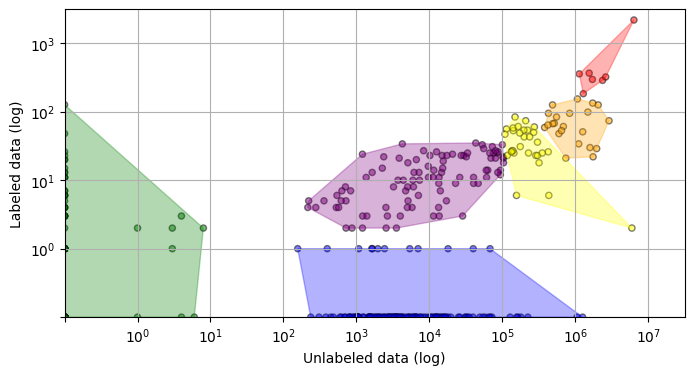

In [86]:
# Draw with Huggingface and area marked

df=drawWithSmoothen(True,True,False,10,False)
lines,allLangCount=printLatexTable(df)

print(allLangCount)
print(lines)

f=open(pathT+"withHugging.tex",'w')
f.write(lines)
f.close()

In [87]:
# View the languages in the top class

df[df[knnYnew]==5]

,Name,ethnolog_Size,ethnolog_Vitality,L1 speakers,L2 speakers,New wiki,Size of Wikipedia (Articles Column),language family,geographical location,geo location analysis,...,Is in Facebook,Joshi Classes,mBERT,HF new,XLMR+mBERT,supevised,Label,12class,NewJoshiClass,Joshi Classes Smooth
279,Arabic,Large,Institutional,350 million,270 million,1174540.0,7.056796,Afro-Asiatic,0,Central Asia,...,1,5,1.0,83.0,29.0,3.553883,Large-Institutional,11,4,5
1076,Chinese,Large,Institutional,1.2 billion,0,1458327.0,7.192012,Sino-Tibetan,"China, Singapore, Taiwan\nCantonese, Hong K...",Eastern Asia,...,1,5,1.0,72.0,1.0,3.564666,Large-Institutional,11,4,5
1486,English,Large,Institutional,360–400 million,750 million,6538164.0,7.805702,Indo-European,"Europe, North America, Australia",Western Europe,...,1,5,1.0,625.0,301.8,4.340841,Large-Institutional,11,4,5
1582,French,Large,Institutional,76.8 million,197 million,2437710.0,7.375905,Indo-European,France,Western Europe,...,1,5,1.0,101.0,57.8,3.459392,Large-Institutional,11,4,5
1698,German,Large,Institutional,90–95 million,10–25 million,2705964.0,7.418692,Indo-European,German,Western Europe,...,1,5,1.0,102.0,67.6,3.509203,Large-Institutional,11,4,5
2193,Japanese,Large,Institutional,~128 million,0,1333645.0,7.112118,Japonic,"Japan (de facto), Palau",Eastern Asia,...,1,5,1.0,53.0,70.3,3.264818,Large-Institutional,11,4,5
5267,Spanish,Large,Institutional,489 million,75 million,1788654.0,7.236042,Indo-European,"Spain, Equatorial Guinea, Western Sahara, Hisp...",Southern Europe,...,1,5,1.0,99.0,54.3,3.472756,Large-Institutional,11,4,5


In [88]:
df[withoutHuggin]=joshiBackup # Re-assign the saved backup

In [89]:
# Finding the languages that shifted class

langDiff=df[(df[withoutHuggin]>df[knnYnew]) | (df[withoutHuggin]<df[knnYnew])][["Name","Label",withoutHuggin,knnYnew]].rename(columns = {knnYnew : "With Huggingface", withoutHuggin:"Without Huggingface"})
langDiff.to_csv(pathC+'langDiff.csv')

## The following are code snippets to draw the above with respect to a given class. These were **not** used in the paper

In [90]:
drawBase=False
drawFacebook=False
drawGoogle=False
drawXLMR=False

In [91]:
if(drawBase):
  drawWithClass('',False,False,False)

In [92]:
if(drawFacebook):
  drawWithClass('Is in Facebook',False,False,False)

In [93]:
if(drawGoogle):
  drawWithClass('Is in Google',False,False,False)

In [94]:
if(drawXLMR):
  drawWithClass('XLMR+mBERT',False,False,False)

# Create the Language Lists to publish (DataSet_Availability list)

In [95]:
aJoshi=df[["Name",knnYnew]].reset_index(drop=True).set_index("Name")
bJoshi=data[["Name","Joshi Classes"]].reset_index(drop=True).set_index("Name")

cJoshi=pd.concat([bJoshi,aJoshi], axis=1, join='outer')
cJoshi=cJoshi.rename(columns={"Joshi Classes": "Joshi", "Joshi Classes Smooth": "New"})
cJoshi["Joshi"] = cJoshi["Joshi"].apply(np.int64)


cJoshi #This gives the original Joshi classes and the newly assigned ones. For languages not included in the original Joshi paper, the value of -1 s given

,Joshi,New
Name,,
!Xóõ,0,0
A-Pucikwar,0,0
Aari,0,0
Aasáx,-1,0
Abadi,-1,0
...,...,...
ǀGwi,-1,0
ǀXam,-1,0
’Are’are,0,0


In [96]:
dataSetlanguagesPath=languagesPath+"Language_Classes_According_To/DataSet_Availability/"

if(not os.path.exists(dataSetlanguagesPath)):
  os.makedirs(dataSetlanguagesPath)

for i in range(6):
  l=cJoshi[cJoshi["New"]==i].reset_index()["Name"].tolist()
  print(l)
  with open(dataSetlanguagesPath+str(i)+'.txt', 'w') as f:
    for line in l:
        f.write(f"{line}\n")

['!Xóõ', 'A-Pucikwar', 'Aari', 'Aasáx', 'Abadi', 'Abai Sungai', 'Abanyom', 'Abau', 'Abaza', 'Abenaki', 'Abidji', 'Abinomn', 'Abishi', 'Abom', 'Abon', 'Abron', 'Abu', 'Abua', 'Abui', 'Abun', 'Abure', 'Abureni', 'Abu’', 'Abé', 'Achagua', 'Achang', 'Ache', 'Acheron', 'Achi', 'Acholi', 'Achterhoeks', 'Achuar-Shiwiar', 'Achumawi', 'Aché', 'Acipa', 'Acroá', 'Adamorobe Sign Language', 'Adang', 'Adangbe', 'Adara', 'Adasen', 'Adele', 'Adi', 'Adioukrou', 'Adithinngithigh', 'Adnyamathanha', 'Adonara', 'Aduge', 'Adzera', 'Aeka', 'Aekyom', 'Aer', 'Afade', 'Afar', 'Afghan Sign Language', 'Afitti', 'Afro-Seminole Creole', 'Agarabi', 'Agariya', 'Agatu', 'Agavotaguerra', 'Aghem', 'Aghu', 'Aghu-Tharnggala', 'Aghul', 'Agi', 'Agob', 'Agoi', 'Agta', 'Aguano', 'Aguna', 'Agutaynen', 'Agwagwune', 'Ahanta', 'Aheu', 'Ahirani', 'Ahom', 'Ahtena', 'Ahwai', 'Ai-Cham', 'Aighon', 'Aikanã', 'Aiklep', 'Aimaq', 'Aimol', 'Ainbai', 'Ainu', 'Aiome', 'Airoran', 'Aisi', 'Aiton', 'Aizi', 'Aja', 'Ajawa', 'Ajiya', 'Ajië', 'Ajum

# Generating Contribution and Coverage tables
* Table 1: The Coverage of the 10 existing Ethnologue language classes in the listed resources. Under each resource, the Count column shows the number of languages in the relevant class included in the resource and the % column
shows that number as a percentage of the total number of languages in the class.
* Table 2: Contribution and Coverage of the 10 existing Ethnologue language classes and Joshi et al. (2020) classes in the listed resources where X+mB refers to the union of XLMR and mBERT. If for Class Ci of total ni members
and a resource Rj of total mj members, the number of members in Ci present in Rj is given by ui,j then, the contribution is 100(ui,j /mj ) and the coverage is 100(ui,j /nj )
* Table 4: The Coverage of the 12 Ethnologue language classes in the CommonCrawl. The Count column shows the number of languages in the relevant
class covered by the CommonCrawl and the % column shows that number as a percentage of the total number of languages in the class.

In [97]:
percentageColumns=['Is in Facebook','Is in Google','XLMR+mBERT']

def countInColumn(tempFrame,column):
  col=tempFrame[column].fillna(0).tolist()
  #print(set(col))
  col=[float(c) for c in col]
  col=[1 if c>0 else 0 for c in col]
  return(round(sum(col),2))


columnTotals={c:countInColumn(data,c) for c in percentageColumns}


def applyToSlice(dfSlice,classN):
  global boxedCoverage
  global boxedContribution

  boxedCoverage[classN]={}
  boxedContribution[classN]={}

  langcount=len(dfSlice)

  for c in percentageColumns:
    colCount=countInColumn(dfSlice,c)
    if(langcount>0):
      boxedCoverage[classN][c+'_cov']=round((100*colCount)/langcount,2)
    else:
      boxedCoverage[classN][c+'_cov']='N/A'
    boxedContribution[classN][c]=round((100*colCount)/columnTotals[c],2)

  boxedCoverage[classN]["Language Count"]=str(langcount)

In [98]:
boxedCoverage={}
boxedContribution={}

jclassesInTable=knnYnew


# Calculate Ethnologue
for s in sizeArr:
  for v in vitalityArr:
    classN=s+"-"+v
    applyToSlice(d[s][v],classN)

# Calculate Joshi
for j in range(len(set(df[jclassesInTable]))):
  joshiSlice=df[df[jclassesInTable]==j]
  applyToSlice(joshiSlice,str(j))

boxedContribution["Total"]=columnTotals

boxedCoverage = pd.DataFrame(boxedCoverage).T
boxedContribution = pd.DataFrame(boxedContribution).T

In [99]:
# Calculate the sums

summableColumns=['LDC','ELRA','Hugginface','Size of Wikipedia (Articles Column)','CC Size','Is in Facebook','Is in Google','XLMR+mBERT','ACL count']

boxed={}
totalFrame = pd.DataFrame()

for s in sizeArr:
  boxed[s]={}
  for v in vitalityArr:
    boxed[s][v]=d[s][v]
    boxed[s][v]=boxed[s][v][boxed[s][v] != 0]  # Drop zero
    boxed[s][v]=boxed[s][v].drop(['Name', 'ethnolog_Size', 'ethnolog_Vitality','universal dependencies'], axis=1)
    for c in summableColumns:
      boxed[s][v][c]=boxed[s][v][c].fillna(0) # Get rid of NaNs
      boxed[s][v][c]=[float(b.replace(",","").replace("-","0").replace(" ","0")) if type(b)==str else b for b in boxed[s][v][c].tolist()]
      boxed[s][v][c]=[1 if c!=0 else 0 for c in boxed[s][v][c].tolist()]
      boxed[s][v][c]=boxed[s][v][c].sum()
    boxed[s][v]=boxed[s][v].dropna(subset=summableColumns)
    boxed[s][v]['Class']=s+"-"+v
    boxed[s][v]['Count']=len(d[s][v]['Name'])
    for c in summableColumns:
      boxed[s][v][c+' Scaled']=round((100*boxed[s][v][c])/boxed[s][v]['Count'],2)
    boxed[s][v]=boxed[s][v].head(1)
    totalFrame=totalFrame.append(boxed[s][v])

def format12ClassNames(s):
  return s.replace("-"," ").title().replace(" ","-")

def getTable(cols,roun):
  global totalFrame
  allCols=makeCols(cols)
  sel=totalFrame[allCols]
  for c,r in zip(cols,roun):
    s=c+' Scaled'
    sel[s]=round(sel[s],r)
  lines=sel.to_latex(index=False)
  lines=lines.replace(".0 &"," &")
  lines=lines.split("\midrule")[1]
  lines=lines.split("\\bottomrule")[0]
  while "&  " in lines:
    lines=lines.replace("&  ","& ")
  while "  &" in lines:
    lines=lines.replace("  &"," &")
  return(lines)

def makeCols(cols):
  newCols=['Class']
  for c in cols:
    newCols=newCols+[c,c+' Scaled']
  return newCols

<ipython-input-99-292806911ebd>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totalFrame=totalFrame.append(boxed[s][v])
<ipython-input-99-292806911ebd>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totalFrame=totalFrame.append(boxed[s][v])
<ipython-input-99-292806911ebd>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totalFrame=totalFrame.append(boxed[s][v])
<ipython-input-99-292806911ebd>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totalFrame=totalFrame.append(boxed[s][v])
<ipython-input-99-292806911ebd>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [100]:
lines=getTable(['LDC','ELRA','Hugginface','Size of Wikipedia (Articles Column)','ACL count'],[3,3,3,3,3])  # '

print(lines)

f=open(pathT+"Conv.tex",'w')
f.write(lines)
f.close()

<ipython-input-99-292806911ebd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel[s]=round(sel[s],r)
<ipython-input-99-292806911ebd>:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=sel.to_latex(index=False)



      Small-Extinct & 1 & 0.30 & 1 & 0.30 & 0 & 0.00 & 1 & 0.30 & 12 & 3.61 \\
   Small-Endangered & 4 & 0.19 & 2 & 0.09 & 13 & 0.60 & 18 & 0.83 & 188 & 8.70 \\
       Small-Stable & 0 & 0.00 & 0 & 0.00 & 1 & 0.09 & 3 & 0.26 & 105 & 8.99 \\
Small-Institutional & 0 & 0.00 & 0 & 0.00 & 1 & 3.57 & 1 & 3.57 & 5 & 17.86 \\
     Mid-Endangered & 1 & 0.22 & 2 & 0.44 & 11 & 2.40 & 28 & 6.11 & 55 & 12.01 \\
         Mid-Stable & 7 & 0.41 & 3 & 0.18 & 4 & 0.24 & 25 & 1.47 & 193 & 11.35 \\
  Mid-Institutional & 4 & 1.92 & 5 & 2.40 & 26 & 12.50 & 45 & 21.63 & 42 & 20.19 \\
   Large-Endangered & 0 & 0.00 & 2 & 14.29 & 3 & 21.43 & 3 & 21.43 & 1 & 7.14 \\
       Large-Stable & 4 & 3.01 & 3 & 2.26 & 9 & 6.77 & 24 & 18.05 & 29 & 21.80 \\
Large-Institutional & 69 & 31.80 & 64 & 29.49 & 121 & 55.76 & 145 & 66.82 & 134 & 61.75 \\



In [101]:
lines=getTable(['CC Size'],[5])

print(lines)

f=open(pathT+"CC.tex",'w')
f.write(lines)
f.close()

<ipython-input-99-292806911ebd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel[s]=round(sel[s],r)
<ipython-input-99-292806911ebd>:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=sel.to_latex(index=False)



      Small-Extinct & 0 & 0.00 \\
   Small-Endangered & 4 & 0.19 \\
       Small-Stable & 0 & 0.00 \\
Small-Institutional & 1 & 3.57 \\
     Mid-Endangered & 4 & 0.87 \\
         Mid-Stable & 2 & 0.12 \\
  Mid-Institutional & 19 & 9.13 \\
   Large-Endangered & 1 & 7.14 \\
       Large-Stable & 4 & 3.01 \\
Large-Institutional & 100 & 46.08 \\



In [102]:
# Create the merged table

lines=boxedContribution.join(boxedCoverage).to_latex()
lines=lines.replace("\n","\n& ")
lines=lines.replace("& Small-Extinct","\\parbox[t]{2mm}{\\multirow{12}{*}{\\rotatebox[origin=c]{90}{\\tiny Ethnologue}}} & Small-Extinct")
lines=lines.replace("& 0","\hline\n\\parbox[t]{2mm}{\\multirow{5}{*}{\\rotatebox[origin=c]{90}{\\tiny\\citet{joshi-etal-2020-state}}}} & 0")
lines=lines.replace("& Total","\hline\n\hline\n\\multicolumn{2}{|c|}{Total}")
lines=lines.replace("NaN","")
lines=lines.split("& \midrule")[1]
lines=lines.split("& \\bottomrule")[0]
while "&  " in lines:
  lines=lines.replace("&  ","& ")
while "  &" in lines:
  lines=lines.replace("  &"," &")
lines=lines.split("Total")
lines[1]=lines[1].replace(".00","")
lines[1]=lines[1].replace("& \\","& "+str(allLangCount)+" \\")
lines="Total".join(lines)
print(lines)

f=open(pathT+"ConVsCov.tex",'w')
f.write(lines)
f.close()

f=open(pathT+"LangsCount.tex",'w')
f.write(str(allLangCount))
f.close()

<ipython-input-102-f41124a6b00b>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=boxedContribution.join(boxedCoverage).to_latex()



\parbox[t]{2mm}{\multirow{12}{*}{\rotatebox[origin=c]{90}{\tiny Ethnologue}}} & Small-Extinct & 0.00 & 0.00 & 0.00 & 0.0 & 0.0 & 0.0 & 332 \\
& Small-Endangered & 4.96 & 0.95 & 0.88 & 0.32 & 0.05 & 0.05 & 2162 \\
& Small-Stable & 0.00 & 0.00 & 0.00 & 0.0 & 0.0 & 0.0 & 1168 \\
& Small-Institutional & 0.00 & 0.95 & 0.00 & 0.0 & 3.57 & 0.0 & 28 \\
& Mid-Extinct & 0.00 & 0.00 & 0.00 & N/A & N/A & N/A & 0 \\
& Mid-Endangered & 5.67 & 1.90 & 4.39 & 1.75 & 0.44 & 1.09 & 458 \\
& Mid-Stable & 3.55 & 0.00 & 1.75 & 0.29 & 0.0 & 0.12 & 1700 \\
& Mid-Institutional & 7.80 & 8.57 & 7.89 & 5.29 & 4.33 & 4.33 & 208 \\
& Large-Extinct & 0.00 & 0.00 & 0.00 & N/A & N/A & N/A & 0 \\
& Large-Endangered & 1.42 & 0.95 & 0.88 & 14.29 & 7.14 & 7.14 & 14 \\
& Large-Stable & 4.26 & 1.90 & 7.02 & 4.51 & 1.5 & 6.02 & 133 \\
& Large-Institutional & 72.34 & 84.76 & 77.19 & 47.0 & 41.01 & 40.55 & 217 \\
\hline
\parbox[t]{2mm}{\multirow{5}{*}{\rotatebox[origin=c]{90}{\tiny\citet{joshi-etal-2020-state}}}} & 0 & 7.80 &

# Generate the ACL publication count graph
* Figure 16: ACL publication count for the 12 Ethnologue language classes (cumulative log)



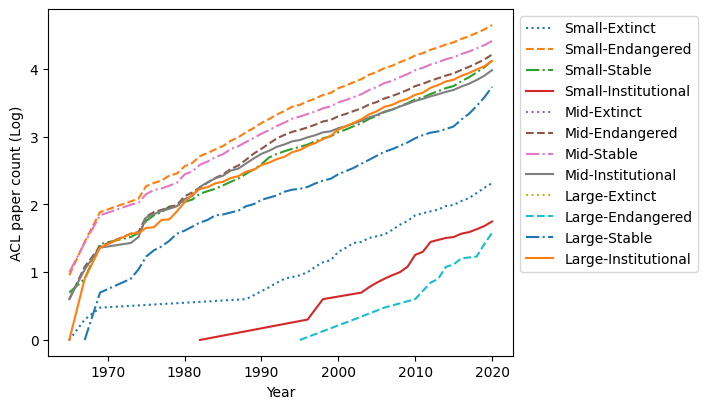

In [103]:
cumilative=True
loged=True
normalized=False
fileName="ACL_graph"
markers=["o","v","^","<",">","1","2","3","4","s","p","P"]
lineStyles=['dotted','dashed','dashdot','solid','dotted','dashed','dashdot','solid','dotted','dashed','dashdot','solid']
series={}

# Need to build the year array
allYears=[]
for s in pubStats:
  for v in pubStats[s]:
    allYears=list(set(allYears+list(pubStats[s][v].keys())))

allYears.sort
allYears=allYears[:-1] # Drop current year

for s in sizeArr:
  for v in vitalityArr:
    key=s+"-"+v
    years=[]
    values=[]
    for y in allYears:
      if y in pubStats[s][v]:
        years.append(y)
        count=sum(list(pubStats[s][v][y].values()))
        if(normalized):
          count=count/len(d[s][v])
        values.append(count)

    if(cumilative):
      for i in range(len(values)):
        if i>0:
          values[i]=values[i]+values[i-1]

    if(loged):
      values=[math.log(v,10) for v in values]

    series[key]=(years,values)


plt.figure(figsize=(6, 4.5), dpi=100)
i=0
for k in series:
  plt.plot(series[k][0], series[k][1], label=k,   linestyle=lineStyles[i])
  i=i+1

plt.xlabel('Year')
ylab='ACL paper count'
if(loged):
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  ylab=ylab+" (Log)"
else:
  plt.legend()

plt.ylabel(ylab)

if(normalized):
  fileName=fileName+"_normalized"

if(cumilative):
  fileName=fileName+"_cumilative"

if(loged):
  fileName=fileName+"_log"

fileName=makeFileNameArxivSafe(fileName)
plt.savefig(pathI+fileName+'.png',bbox_inches='tight', dpi=500)

# Generate Population vs Wikipedia article count graph
* Figure 13: Speaker Population (log) vs Wikipedia Article Count (log)

**Note:** Some of the functions that are defined here are then later used for the GDP vs Wikipedia graph below.

In [104]:
# Our data annotators had introduced a number of complexities to this data column. We are cleaning the column here.

def processPopulationCount(s):
  if type(s)==int:
    return s  # No problem!

  s=s.replace("-","–") # Homogenize the dashes

  # Get the upper limit when there is a range
  if "–" in s:
    s=s.split("–")[1]
  elif "to" in s:
    s=s.split("to")[1]

  s=s.replace("~","") # Get rid of the approximate symbol

  s=s.replace("±","") # Get rid of the second approximate symbol

  s=s.replace("≈","") # Get rid of the third approximate symbol

  s=s.replace("<","") # Get rid of the less than symbol

  s=s.replace(",","") # Get rid of the commas

  s=s.replace("c.","") # Get rid of the c.

  s=s.replace("ca.","") # Get rid of the ca.

  s=s.strip() # Get rid of the white spaces

  # Now handle million and billion
  if " " in s:
    s=s.split(" ")
    s[0]=float(s[0])
    if 'million' in s[1]:
      s[0]=s[0]*1000000
    if 'billion' in s[1]:
      s[0]=s[0]*1000000000
    s=s[0]
  else:
    s=int(s)

  return int(s)

<ipython-input-105-c9b68b5d4c0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popchart[c]=[processPopulationCount(s) if s!=0 else 0 for s in popchart[c].tolist()]
<ipython-input-105-c9b68b5d4c0a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popchart[sp] = popchart[spList].sum(axis=1) # Rows
<ipython-input-105-c9b68b5d4c0a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

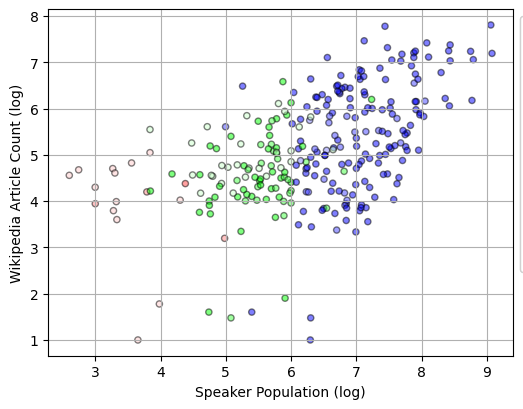

In [105]:
spList=["L1 speakers","L2 speakers"]
sp="speakers"
wk="Size of Wikipedia (Articles Column)"
#wk='perCap'
classN="12class"

fileName=sp+"_vs_"+wk
fileName=fileName.replace(" ","_")


popchart=df[["Name",wk,classN]+spList]

# Fix the horrible formatting of L1 and L2
for c in spList:
  popchart[c]=[processPopulationCount(s) if s!=0 else 0 for s in popchart[c].tolist()]


popchart[sp] = popchart[spList].sum(axis=1) # Rows

popchart[sp] =[math.log(s,10) if s!=0 else 0 for s in popchart[sp].tolist()] # Now take log

popchart=popchart[(popchart[sp] != 0) & (popchart[wk] != 0)]


fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)


scatter = ax.scatter(popchart[sp].tolist(), popchart[wk].tolist(),s=20,c=popchart[classN].tolist(), alpha=0.5,cmap=newcmp, edgecolor='black')
handles = scatter.legend_elements(num=range(len(classes12)))[0]  # Extract the handles from the existing scatter plot

# Produce a legend with the unique colours from the scatter
classes12N=[format12ClassNames(c) for c in classes12]
legend1 = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Classes", handles=handles, labels=classes12N)
ax.add_artist(legend1)

plt.grid()
plt.ylabel("Wikipedia Article Count (log)")
plt.xlabel("Speaker Population (log)")

fileName=makeFileNameArxivSafe(fileName)
plt.savefig(pathI+fileName+'.png',bbox_inches='tight', dpi=500)

In [106]:
# Calculate the Pearson correlation

lines=popchart[[sp,wk]].corr().to_latex()
lines=lines.split("\midrule")[1]
lines=lines.split("\\bottomrule")[0]
lines=lines.split(") &")[1]
lines=lines.split("&")[0]
lines=lines.strip()
print(lines)

f=open(pathT+"Corr.tex",'w')
f.write(lines)
f.close()

<ipython-input-106-bac0cf41f0af>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=popchart[[sp,wk]].corr().to_latex()


0.518148


# Generate ‘Distribution of Languages’ horizontal bar graphs
* Figure 11: The distribution of languages that have wikis among the 12 Ethnologue Classes - By Geographical Location
* Figure 12: The distribution of languages that have wikis among the 12 Ethnologue Classes - By Language Families


In [107]:
def drawBarGraph(barClass,showAxis):
  ethnoStats={}
  labels =[]
  width =0.9  # The width of the bars: can also be len(x) sequence

  postfix="_Dist"
  fileName=barClass+postfix
  fileName=fileName.replace(" ","_")


  df2=data.fillna(0)

  df2=df2[df2[barClass]!=0]

  df2[barClass]=[l.replace("–","-") for l in df2[barClass].tolist()]


  langFamiliesList=list(set(df2[barClass]))

  langFamiliesList.sort()

  langFamilies={}

  for lf in langFamiliesList:
    langFamilies[lf]=df2[df2[barClass]==lf]

  fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

  for lf in langFamiliesList:
    labels.append(lf.title())
    sliced=df2[(df2[barClass]==lf)]
    sliceLen=len(sliced)
    for s in sizeArr:
        for v in vitalityArr:
          classN=s+"-"+v
          if classN not in ethnoStats:
            ethnoStats[classN]=[]
          count=len(sliced[(sliced["ethnolog_Size"]==s)&(sliced["ethnolog_Vitality"]==v)])
          ethnoStats[classN].append(count/sliceLen)

  bottom=[0] * len(langFamiliesList)
  for classN,c in zip(ethnoStats,colourNames):
    classNs=format12ClassNames(classN)
    if sum(bottom)==0:
      ax.barh(labels, ethnoStats[classN], width,color=c,  label=classNs)
    else:
      ax.barh(labels, ethnoStats[classN],width,color=c, left=bottom,  label=classNs)
    bottom=[sum(x) for x in zip(bottom, ethnoStats[classN])]


  legend=ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Classes", ncol=4)

  plt.ylabel("Class Fraction")
  plt.xlabel(barClass.title())
  if(not showAxis):
    legend.remove()
  else:
    fileName="Axis"+postfix

  fileName=makeFileNameArxivSafe(fileName)
  plt.savefig(pathI+fileName+'.png',bbox_inches='tight', dpi=500)

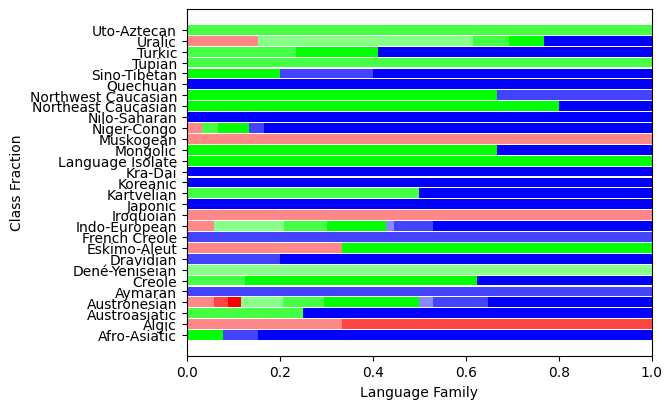

In [108]:
drawBarGraph("language family",False)

2042 3361


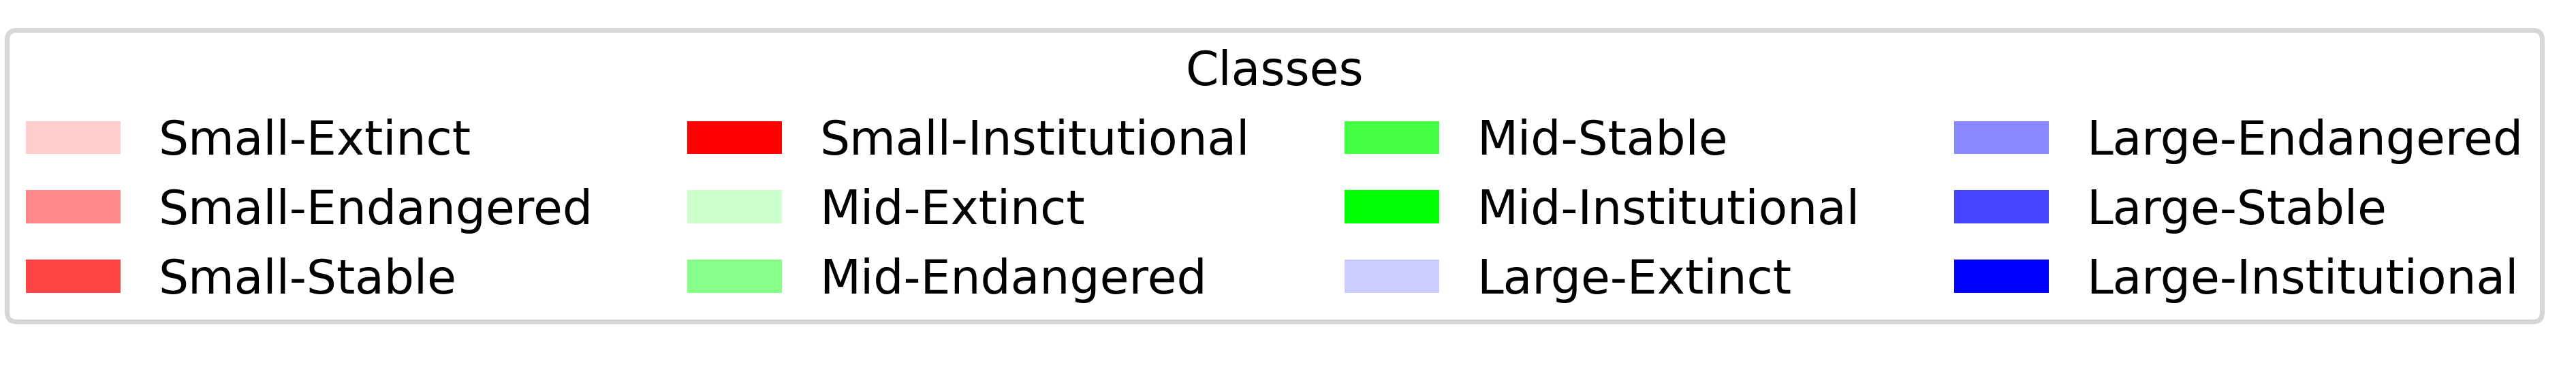

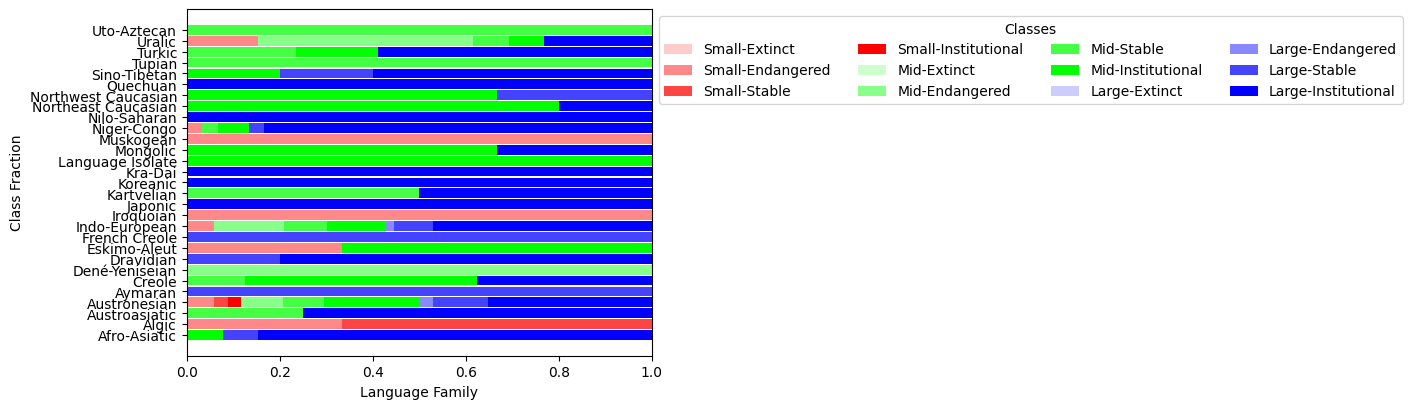

In [109]:
# Extract the axis image

drawBarGraph("language family",True)
cropAxis("language_family_Dist","Axis_Dist",40,1450,80)

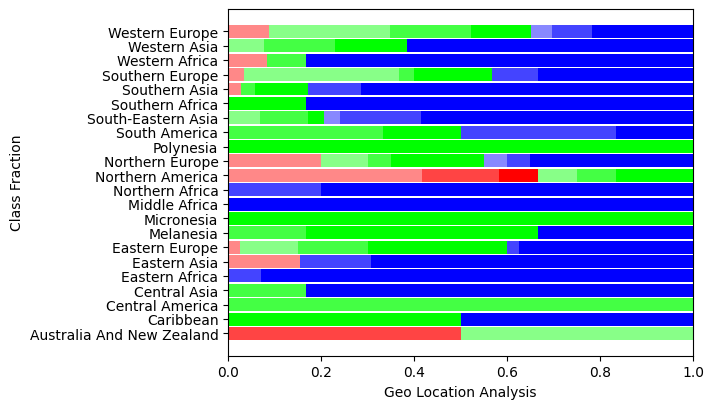

In [110]:
drawBarGraph("geo location analysis",False)

# Generate ‘Distribution of Resources’ horizontal bar graphs
* Figure 2: The Distribution of Resources
* Figure 14: By Geographical Location of the Language Origin
* Figure 15: By Language Families


In [111]:
resourceColumns={"Size of Wikipedia (Articles Column)":"Wikipedia",
                 "Hugginface":"Hugginface",
                 "LDC":"LDC",
                 "ELRA":"ELRA",
                 "XLMR+mBERT":"XLMR+mBERT",
                 "ACL count":"ACL",
                 "Is in Google":"Google",
                 "Is in Facebook":"Facebook"
                }

def drawBarGraphResources(perspective,cl,y,colourMap,showAxis):
  resourceStats={}
  labels =[]
  width =0.9  # The width of the bars: can also be len(x) sequence

  postfix="_resource_Dist"
  fileName=perspective+postfix
  fileName=fileName.replace(" ","_")


  df2=data.fillna(0)

  # Clean out the irrelevant strings the data annotators have added.
  for r in resourceColumns:
    df2[r]=pd.to_numeric(df2[r],errors='coerce')
    df2[r]=df2[r].fillna(0)

  df2["Temp"]= df2[list(resourceColumns.keys())].sum(axis=1) # Rows sum
  df2=df2[df2["Temp"]!=0]  # Now drop if sum is zero

  df2=df2[df2[perspective]!=0] # Now drop if the perspective is zero

  df2[perspective]=[l.replace("–","-") for l in df2[perspective].tolist()]

  langFamiliesList=list(set(df2[perspective]))

  langFamiliesList.sort()

  fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

  for rc in resourceColumns:
    labels.append(resourceColumns[rc])
    sliced=df2[(df2[rc]>0)]
    sliceLen=len(sliced)

    for lf in langFamiliesList:
      if lf not in resourceStats:
        resourceStats[lf]=[]
      count=len(sliced[(sliced[perspective]==lf)])
      resourceStats[lf].append(count/sliceLen)

  bottom=[0] * len(list(resourceColumns.keys()))

  for classN in colourMap:
    c=colourMap[classN]
    classNs=classN
    if sum(bottom)==0:
      ax.barh(labels, resourceStats[classN], width,color=c,  label=classNs)
    else:
      ax.barh(labels, resourceStats[classN],width,color=c, left=bottom,  label=classNs)
    bottom=[sum(x) for x in zip(bottom, resourceStats[classN])]

  legend=ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title=cl, ncol=2)

  plt.xlabel("Class Fraction")
  plt.ylabel(y)
  if(not showAxis):
    legend.remove()

  fileName=makeFileNameArxivSafe(fileName)
  plt.savefig(pathI+fileName+'.png',bbox_inches='tight', dpi=500)

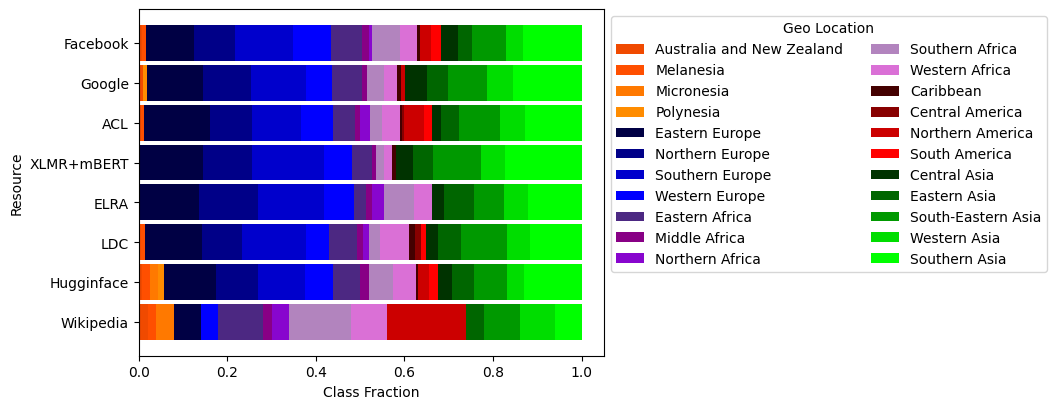

In [112]:
geoColours={
  'Australia and New Zealand':"#F04A00",
  'Melanesia':"#FF4F00",
  'Micronesia':"#FF7900",
  'Polynesia':"#FF8C00",

  'Eastern Europe':"#000044",
  'Northern Europe':"#000088",
  'Southern Europe':"#0000CC",
  'Western Europe':"#0000FF",

  'Eastern Africa':"#4C2882",
  'Middle Africa':"#880085",
  'Northern Africa':"#8806CE",
  'Southern Africa':"#B284BE",
  'Western Africa':"#DA70D6",

  'Caribbean':"#440000",
  'Central America':"#880000",
  'Northern America':"#CC0000",
  'South America':"#FF0000",


 'Central Asia':"#003300",
 'Eastern Asia':"#006600",
 'South-Eastern Asia':"#009900",
 'Western Asia':"#00DD00",
 'Southern Asia':"#00FF00",

 }



drawBarGraphResources("geo location analysis","Geo Location","Resource",geoColours,True)

Seed was: 8289796525687180299


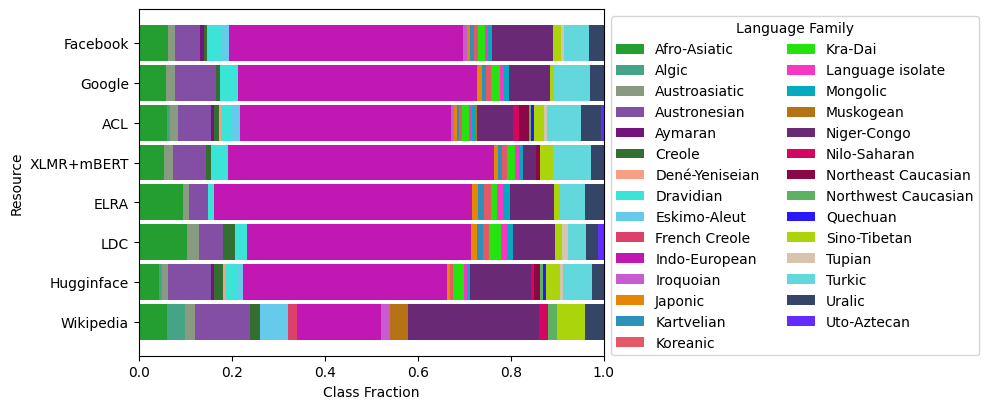

In [113]:
# **Note:** The colours are randomized.
# Some sample seeds that worked well: 2262264242078653279,2199217718325811020,8822979612487266713

seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

languageFamilyColours={}

languageFamilySet=list(set(data["language family"].dropna()))
languageFamilySet.sort()


for lfc in  languageFamilySet:
  languageFamilyColours[lfc.replace("–","-")]="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])


drawBarGraphResources("language family","Language Family","Resource",languageFamilyColours,True)

# Generate various counts and summaries that were reported in the paper

In [114]:
# Languages that have changed their Joshi class

df[(df[withoutHuggin]!=df[knnYnew])][["Name","Without Huggingface Joshi","Joshi Classes Smooth"]]

,Name,Without Huggingface Joshi,Joshi Classes Smooth
15,Abkhaz,1,2
61,Afrikaans,3,2
113,Akan,1,2
145,Albanian,1,2
280,Aragonese,1,2
...,...,...,...
5928,Venda,1,2
6011,Walloon,1,2
6107,Welsh,1,3
6226,Yakut,1,2


In [115]:
# Non-blues that are in the blue area of the population chart

popchart[(popchart["L1 speakers"]+popchart["L2 speakers"]>=1000000)&(popchart["12class"]<=7)]

,Name,Size of Wikipedia (Articles Column),12class,L1 speakers,L2 speakers,speakers
379,Avar,4.405858,7,1000000,0,6.000000
1476,Emilian,5.111599,5,4400000,0,6.643453
1764,Gorontalo,5.087036,5,1000000,0,6.000000
1791,Guaraní,4.643650,6,6500000,0,6.812913
2275,Kabiyè,4.226342,6,1000000,0,6.000000
3248,Low German,6.197272,7,7150000,10000000,7.234264
3802,Mon,3.959995,6,1000000,0,6.000000
3974,Nahuatl,4.846399,6,1700000,0,6.230449
4637,Piedmontese,5.818602,5,2000000,0,6.301030
4847,Romani,3.847573,6,3500000,0,6.544068


In [116]:
# Reds that are in the green/blue area of the population chart

popchart[(popchart["L1 speakers"]+popchart["L2 speakers"]>=10000)&(popchart["12class"]<=3)]

,Name,Size of Wikipedia (Articles Column),12class,L1 speakers,L2 speakers,speakers
1148,Cree,3.195900,2,96000,0,4.982271
1921,Hawaiian,4.378943,3,24000,0,4.380211
5027,Seediq,4.021189,1,20000,0,4.301030


# Calculating 6 Months of Huggingface and Wiki difference
* Table 11: The number of datasets available in Huggingface for the 12 Ethnologue language classes in November 2021 compared with July 2022.
* Table 12: The number of datasets available in Wikipedia for the 12 Ethnologue language classes in November 2021 compared with July 2022

In [117]:
def getDifference(oldColumn,newColumn):

  dfClassCount=df.groupby(['Label']).agg({'Name':'count'}).rename(columns={"Name":"Count"})

  dfShift=data[["Name",oldColumn,newColumn]]
  dfShift['Label']=df['Label']
  dfShift=dfShift.dropna()

  dfShift=dfShift[["Name","Label",oldColumn,newColumn]]

  dfShift[oldColumn]=pd.to_numeric(dfShift[oldColumn],errors='coerce')
  dfShift[oldColumn]=dfShift[oldColumn].fillna(0)
  dfShift = dfShift.astype({oldColumn:'int'})

  dfShift[newColumn]=pd.to_numeric(dfShift[newColumn],errors='coerce')
  dfShift = dfShift.astype({newColumn:'int'})
  dfShift=dfShift[dfShift[newColumn] != 0]

  dfShift=dfShift.groupby(['Label'])[[oldColumn,newColumn]].agg('sum')

  dfShift['Diff'] = dfShift[newColumn] - dfShift[oldColumn]

  dfShift=dfClassCount.join(dfShift)

  dfShift=dfShift.fillna(0).astype({newColumn:'int',oldColumn:'int',"Diff":'int'})

  oldColumnNorm=oldColumn+"_Norm"
  newColumnNorm=newColumn+"_Norm"

  dfShift[oldColumnNorm]=dfShift[oldColumn]/dfShift["Count"]
  dfShift[newColumnNorm]=dfShift[newColumn]/dfShift["Count"]
  dfShift["Diff_Norm"]=dfShift["Diff"]/dfShift["Count"]

  dfShift=dfShift.round({oldColumnNorm: 2, newColumnNorm: 2, "Diff_Norm": 2})

  dfShift=dfShift[["Count",oldColumn,oldColumnNorm,newColumn,newColumnNorm,"Diff","Diff_Norm"]]

  lines=dfShift.to_latex()

  return(lines)

In [118]:
print(getDifference("Hugginface","HF new"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Count &  Hugginface &  Hugginface\_Norm &  HF new &  HF new\_Norm &  Diff &  Diff\_Norm \\
Label               &        &             &                  &         &              &       &            \\
\midrule
Large-Endangered    &     14 &          27 &             1.93 &      31 &         2.21 &     4 &       0.29 \\
Large-Institutional &    217 &        3529 &            16.26 &    3994 &        18.41 &   465 &       2.14 \\
Large-Stable        &    133 &          51 &             0.38 &      75 &         0.56 &    24 &       0.18 \\
Mid-Endangered      &    458 &          86 &             0.19 &     101 &         0.22 &    15 &       0.03 \\
Mid-Institutional   &    208 &         228 &             1.10 &     271 &         1.30 &    43 &       0.21 \\
Mid-Stable          &   1700 &          24 &             0.01 &      31 &         0.02 &     7 &       0.00 \\
Small-Endangered    &   2162 &          38 &             0.02 &      45 &         

<ipython-input-117-2137d01fb79e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfShift['Label']=df['Label']
<ipython-input-117-2137d01fb79e>:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=dfShift.to_latex()


In [119]:
oldColumn="Size of Wikipedia (Articles Column)"
newColumn="New wiki"

print(getDifference(oldColumn,newColumn))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Count &  Size of Wikipedia (Articles Column) &  Size of Wikipedia (Articles Column)\_Norm &  New wiki &  New wiki\_Norm &      Diff &  Diff\_Norm \\
Label               &        &                                      &                                           &           &                &           &            \\
\midrule
Large-Endangered    &     14 &                                    0 &                                      0.00 &     77070 &        5505.00 &     77070 &    5505.00 \\
Large-Institutional &    217 &                              1243317 &                                   5729.57 &  54612595 &      251670.94 &  53369278 &  245941.37 \\
Large-Stable        &    133 &                                22124 &                                    166.35 &   1085994 &        8165.37 &   1063870 &    7999.02 \\
Mid-Endangered      &    458 &                                18028 &                                     39.36 &    650903 &

<ipython-input-117-2137d01fb79e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfShift['Label']=df['Label']
<ipython-input-117-2137d01fb79e>:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=dfShift.to_latex()


In [120]:
# Some wikis were noted to have lost pages instead of gained. This might be due to admins removing low-quality pages.

oldColumn="Size of Wikipedia (Articles Column)"
newColumn="New wiki"

wikiSanity=data[["Name",oldColumn,newColumn]]

wikiSanity[oldColumn]=pd.Series(wikiSanity[oldColumn]).str.replace('-', '0', regex=True)
wikiSanity[oldColumn]=pd.Series(wikiSanity[oldColumn]).str.replace(',', '', regex=True)

wikiSanity[oldColumn]=pd.to_numeric(wikiSanity[oldColumn],errors='coerce')
wikiSanity[newColumn]=pd.to_numeric(wikiSanity[newColumn],errors='coerce')
wikiSanity=wikiSanity.fillna(0)
wikiSanity = wikiSanity.astype({oldColumn:'int',newColumn:'int'})

wikiSanity[wikiSanity[oldColumn]>wikiSanity[newColumn]]

<ipython-input-120-9b1bd27646ec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikiSanity[oldColumn]=pd.Series(wikiSanity[oldColumn]).str.replace('-', '0', regex=True)
<ipython-input-120-9b1bd27646ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wikiSanity[oldColumn]=pd.Series(wikiSanity[oldColumn]).str.replace(',', '', regex=True)
<ipython-input-120-9b1bd27646ec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,Name,Size of Wikipedia (Articles Column),New wiki
58,Afar,1,0
113,Akan,4007,2078
149,Alemannic,68048,28926
181,Amazigh,6209,0
391,Awadhi,2439,2436
425,Azerbaijani,744664,427087
656,Belarusian,427384,298641
768,Bishnupuriya,25088,25084
771,Bislama,1394,1393
1039,Chavacano,3150,3125


In [121]:
# Some wikis were started in the 6 months that are considered here

wikiSanity[(wikiSanity[oldColumn]==0) & (wikiSanity[newColumn]>0)]

,Name,Size of Wikipedia (Articles Column),New wiki
201,Amis,0,825
1823,Gun,0,920
2836,Kuan,0,4
4497,Paiwan,0,276
4946,Samoan,0,1064
5791,Tyap,0,430


In [122]:
# Wikis that were created or completely removed within the considered 6 months

wikiSanity[((wikiSanity[oldColumn]==0) & (wikiSanity[newColumn]>0))|((wikiSanity[oldColumn]>0) & (wikiSanity[newColumn]==0))]

,Name,Size of Wikipedia (Articles Column),New wiki
58,Afar,1,0
181,Amazigh,6209,0
201,Amis,0,825
1512,Esperanto,304582,0
1823,Gun,0,920
2836,Kuan,0,4
4353,N’ko,1047,0
4497,Paiwan,0,276
4946,Samoan,0,1064
5791,Tyap,0,430


# Calculating the difference in being included in XML-R vs being a Large-Institutional language class

In [123]:
def printXdifFile(l,fName):
  g = open(pathC+fName+".txt", "w")
  for t in l:
    g.write(str(t)+"\n")
  g.close()

In [124]:
anName="XLMR_no_but_Large-Institutional_yes"

XDiff=df[(df['XLMR+mBERT']==0) & (df['Label']=='Large-Institutional') & (df['Size of Wikipedia (Articles Column)']>0)]  #

printXdifFile(XDiff["Name"].tolist(),anName)

In [125]:
xDiffRanges=XDiff.groupby(["geo location analysis"]).count()

xDiffRanges["Name"].to_csv(pathC+anName+"_[Geo].csv", index=True)

In [126]:
XDiff.to_csv(pathC+anName+".csv",index=False)

In [127]:
anName="XLMR_yes_but_Large-Institutional_no"

XDiff=df[(df['XLMR+mBERT']>0) & (df['Label']!='Large-Institutional') & (df['Size of Wikipedia (Articles Column)']>0)]   #

printXdifFile(XDiff["Name"].tolist(),anName)

In [128]:
xDiffRanges=XDiff.groupby(["geo location analysis"]).count()

xDiffRanges["Name"].to_csv(pathC+anName+"_[Geo].csv", index=True)

In [129]:
XDiff.to_csv(pathC+anName+".csv",index=False)

# Re-Generating the ACL Bubble plot using the ACL counts obtained by extending Blasi's code and using Rohatgi's data set
* Figure 1: The 12 Ethnologue language classes where the size of each outer circle corresponds to the number of languages in that category and the size of each red circle corresponds to the coverage of that class in the relevant resource. [Only (h) ACL Anthology]

## This is is a adapted version of ACL language search [code from Blasi et al. (2022)](https://github.com/neubig/globalutility/tree/main/anthology_exp)

In [130]:
all_languages={}
languages_to_ignore ="Laura,Fang,Mono,Ma,Maria,Sam,Bench,Zhuang,Male,Nara,So,Hu,Kim,Label,The,To,Yong,The,To,Adele,Are,Foma,Kaur,Bau,Kato,Dek,Naman,Dom,As,The,To,As,Dan,E,The,To,U,Even,En,Chung,Dong,Shi,Tai,Thompson,Gao,Ir,Pan,Ali,Rao,Han,Doe,Titan,Ha,Sa,Tu,Lau,Siri,Wan,She,Dai,Ding,Kang,Ge,Koch,Che,Mann,Zou,Pei,Yao,Lou,Sydney,Ju,Sha,Day,Miwa,Bai,Ko,Ga,Pal,Pe,Gun,Hung,Con,Cun,Serrano,Sui,Bu,Mehri,Od,Haji,Gal,Gey,Lui,Ho,Furu,Ak,Kao,Aro,Gen,Moro,Notre,Ido,Ron,Were,Bai,Sahu,Dem,Melo,Rama,Hunde,Dii,Yala,Sauri".split(',')
languages_to_ignore=languages_to_ignore+"Uni,One,Yi,Na,Bit,Pa".split(',')

with open(ourLangsPath) as ourLangs:
	for name in ourLangs:
		name=name.replace("\n","")
		if name not in languages_to_ignore:
			all_languages[name] = (name,"dummy_glottocode")

In [131]:
# We need to fetch the 'macrolanguages.tsv' file from their Github repo

macrolanguagesPath=inputPath+"macrolanguages.tsv"

r = requests.get('https://raw.github.com/neubig/globalutility/main/anthology_exp/macrolanguages.tsv')

with open(macrolanguagesPath, 'wb') as f:
    f.write(r.content)

In [132]:
# Load the fetched macrolanguages

macrolist = {}
with open(macrolanguagesPath) as inp:
	lines = inp.readlines()
for l in lines:
	l = l.strip().split('\t')
	iso = l[0]
	name = l[1]
	iso2 = l[2]
	name2 = l[3]
	all_languages[name] = (name,"dummy_glottocode") #iso
	if name2 in all_languages:
		macrolist[name2] = name

In [133]:
def search_languages_inText(text,verbose):
	langlist = []
	for l in all_languages:
		ADD_MACRO = False
		if l in macrolist:
			ADD_MACRO = True
		if ' '+l+' ' in text:
			if(verbose):
				print(l,all_languages[l][0])
			langlist.append(all_languages[l][0])
			if ADD_MACRO and macrolist[l] in all_languages:
					langlist.append(all_languages[macrolist[l]][0])
		elif ' '+l+',' in text:
			if(verbose):
				print(l,all_languages[l][0])
			langlist.append(all_languages[l][0])
			if ADD_MACRO and macrolist[l] in all_languages:
				langlist.append(all_languages[macrolist[l]][0])
		elif ' '+l+'.' in text:
			if(verbose):
				print(l,all_languages[l][0])
			langlist.append(all_languages[l][0])
			if ADD_MACRO and macrolist[l] in all_languages:
				langlist.append(all_languages[macrolist[l]][0])
	return langlist

## Get the current ACL data from [Rohatgi -ACL Anthology Corpus with Full Text](https://github.com/shauryr/ACL-anthology-corpus) and generate the language counts file.

Navigate to the [Google drive link](https://drive.google.com/file/d/1CFCzNGlTls0H-Zcaem4Hg_ETj4ebhcDO/view) and add 'acl-publication-info.74k.parquet' to your Input folder. You do not have to download the file. Adding a link is sufficient.

In [135]:
aclAllpath=intermediatePath+"fullACL_anthology_citation_language_info.tsv"
resumeFileConstruction=False # Set this to True to resume the construction of a part-created file. Added this because the task takes 10-12 hours and Google Collab often disconnects in the middle of that.
x=-1

if (os.path.isfile(aclAllpath) and (not resumeFileConstruction)):
  print("It seems the 'fullACL_anthology_citation_language_info.tsv' file already exists.")
  print("And you have set the resumeFileConstruction variable to False")
  print("We are skipping this step")
else:
  # If you wish to regenerate 'fullACL_anthology_citation_language_info.tsv', please delete the the file and re-run"
  # Warning, this task will take around 10-12 hours
  # If instead, you wish to continue constructing a part-created 'fullACL_anthology_citation_language_info.tsv', set resumeFileConstruction to True and re-run without deleting the part-created file

  RohatgiACLdf = pd.read_parquet(inputPath+'acl-publication-info.74k.parquet')

  aclIDs=RohatgiACLdf["acl_id"].tolist()
  aclPapers=RohatgiACLdf["full_text"].tolist()

  for aclID,aclPaper,i in tqdm(zip(aclIDs,aclPapers,range(len(aclPapers))),total=len(aclPapers)):
    if(resumeFileConstruction):
      if(x<0):
        f=open(aclAllpath, "r")
        x = len(f.readlines())
        f.close()
      f=open(aclAllpath, "a")
    else:
      f=open(aclAllpath, "w")
      resumeFileConstruction=True
    if(i>=x):
      langs = search_languages_inText(aclPaper,False)
      langs =list(set(langs))
      f.write(f"{aclID}\t{','.join(langs)}\n")
    if(i%100==0):
      f.flush()
      f.close()
      f=open(aclAllpath, "a")

  f.close()


It seems the 'fullACL_anthology_citation_language_info.tsv' file already exists.
And you have set the resumeFileConstruction variable to False
We are skipping this step


## Create the language count JSON file
We are creating this by reading the file from the disk instead of handing a data structure from the above block to this one because, as mentioned above, Google collab may have crashed and the in memory data structure may not be consistant.
You might also have to re-start the runtime at this point if it keeps loading an old verison of the file. As long as you have set the variable of the above block correct, it should work.

In [136]:
BlasiACLcounts={}

with open(aclAllpath) as op:
  for line in op:
    line=line.split("\t")
    line[-1]=line[-1].replace("\n","")
    if(len(line[1])>0):
      line=line[1].split(",")
      for l in line:
        if l in BlasiACLcounts:
          BlasiACLcounts[l]=BlasiACLcounts[l]+1
        else:
          BlasiACLcounts[l]=1

In [137]:
jsonPath=intermediatePath+"fullACL_BlasiCounts.json"

# Serializing json
json_object = json.dumps(BlasiACLcounts, indent=4)

# Writing to sample.json
with open(jsonPath, "w",encoding='utf8') as outfile:
  outfile.write(json_object)

## Re-generate the ACL bubble plot

In [138]:
f = open(jsonPath, 'r') # Opening JSON file
BlasiACL = json.load(f) # Returns JSON object as a dictionary
f.close() # Closing file

BlasiACL=pd.json_normalize(BlasiACL).T

In [139]:
bl="Name"

BlasiACL[bl]=BlasiACL.index
BlasiACL.columns = ['BlasiCounts', bl]

In [140]:
data=pd.merge(data,BlasiACL,on=bl,how="left")

In [141]:
d=makeD()

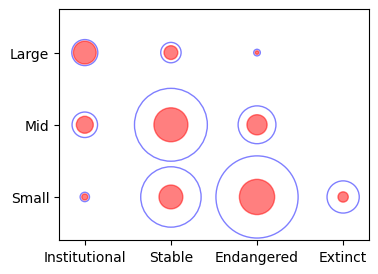

In [142]:
plotBubbleGraph('BlasiCounts')

# Generating stat table for HuggingFace Data Sets
* Table 6: Datasets for different task-language category combinations (Excluding the 50 tasks that are not tagged
with any language).

## Fetch the HuggingFace data

In [143]:
HuggingFaceJSONPath=intermediatePath+"HuggingFace_counts.json"

def writeJSON(c):
  # Serializing json
  json_object = json.dumps(c, indent=4)

  # Writing to sample.json
  with open(HuggingFaceJSONPath, "w") as outfile:
      outfile.write(json_object)

def readJSON():
  f = open(HuggingFaceJSONPath, 'r') # Opening JSON file
  data = json.load(f) # Returns JSON object as a dictionary
  f.close() # Closing file
  return(data)

In [144]:
resumeCrawl=True

counts={}

# If you want to re-do this part and fetch data from HuggingFace anew, just delete 'HuggingFace_counts.json' file and re-run this code
if(os.path.isfile(HuggingFaceJSONPath)):
  counts=readJSON()

i=1
total=len(HuggingFaceLangs)
for l in HuggingFaceLangs:
  print(i,"/",total,":",l)
  if l in counts:
    print("Already done")
  else:
    counts[l]={}
    for tc in tqdm(HuggingFaceTaskCategories):
      url="https://huggingface.co/datasets?language=language:"+HuggingFaceLangs[l]+"&task_categories=task_categories:"+tc
      h=requests.get(url)
      h=h.text
      soup = BeautifulSoup(h, 'html.parser')  # Parse the html file
      soup= soup.find_all("div", {"class": "flex items-center text-lg"})[0].find_all("div", {"class": "ml-3 font-normal text-gray-400 w-16"})[0].getText()
      counts[l][tc]=soup
    print("Attempting to write to file")
    writeJSON(counts)
  i=i+1

1 / 188 : English
Already done
2 / 188 : German
Already done
3 / 188 : French
Already done
4 / 188 : Spanish
Already done
5 / 188 : Russian
Already done
6 / 188 : Arabic
Already done
7 / 188 : Polish
Already done
8 / 188 : Portuguese
Already done
9 / 188 : Chinese
Already done
10 / 188 : Turkish
Already done
11 / 188 : Dutch
Already done
12 / 188 : Italian
Already done
13 / 188 : Finnish
Already done
14 / 188 : Swedish
Already done
15 / 188 : Korean
Already done
16 / 188 : Catalan
Already done
17 / 188 : Indonesian
Already done
18 / 188 : Romanian
Already done
19 / 188 : Japanese
Already done
20 / 188 : Czech
Already done
21 / 188 : Danish
Already done
22 / 188 : Greek
Already done
23 / 188 : Hindi
Already done
24 / 188 : Thai
Already done
25 / 188 : Hungarian
Already done
26 / 188 : Slovenian
Already done
27 / 188 : Vietnamese
Already done
28 / 188 : Bulgarian
Already done
29 / 188 : Estonian
Already done
30 / 188 : Bengali
Already done
31 / 188 : Latvian
Already done
32 / 188 : Lithu

In [145]:
HuggingFaceDataFrames={}

for l in counts:
  HuggingFaceDataFrames[l]=pd.json_normalize(counts[l])
  HuggingFaceDataFrames[l]["Name"]=l

In [146]:
append=False

allFrame=[]

for l in counts:
  if(append):
    allFrame=allFrame.append(HuggingFaceDataFrames[l], ignore_index = True)
  else:
    allFrame=HuggingFaceDataFrames[l]
    append=True

<ipython-input-146-b9f6d39b6497>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allFrame=allFrame.append(HuggingFaceDataFrames[l], ignore_index = True)


In [147]:
huggingFaceDataSetPath=intermediatePath+"HuggingFace-Datasets.csv"

allFrame.to_csv(huggingFaceDataSetPath,index=False)

## Load the HuggingFace data and generate the table

In [148]:
huggingFaceDataSets=pd.read_csv(huggingFaceDataSetPath, thousands=',')

In [149]:
data=pd.merge(data,huggingFaceDataSets,on=bl,how="left")

In [150]:
columsToSelct=huggingFaceDataSets.columns.tolist()
columsToSelct=columsToSelct+["ethnolog_Size","ethnolog_Vitality"]

In [151]:
dataHuggn=data[columsToSelct]

dataHuggn=dataHuggn.dropna(subset=["text-classification"])

dataHuggn["Class"]=dataHuggn["ethnolog_Size"]+"-"+dataHuggn["ethnolog_Vitality"]

dataHuggn=dataHuggn.groupby(['Class']).sum().T

dataHuggn=dataHuggn[columnSorter]

dataHuggn["Sum"]=dataHuggn[columnSorter].sum(axis=1)

dataHuggnSelected=dataHuggn[dataHuggn["Sum"]>0]

dataHuggnSelected=dataHuggnSelected.sort_values(by='Sum', ascending=False)

dataHuggnSelected=dataHuggnSelected[columnSorter]

dataHuggnSelected=dataHuggnSelected.astype(int)

dataHuggnSelected.to_latex()

<ipython-input-151-8f63720e88a6>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataHuggn=dataHuggn.groupby(['Class']).sum().T
<ipython-input-151-8f63720e88a6>:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataHuggnSelected.to_latex()


'\\begin{tabular}{lrrrrrrrr}\n\\toprule\nClass &  Large-Institutional &  Large-Stable &  Large-Endangered &  Mid-Institutional &  Mid-Stable &  Mid-Endangered &  Small-Stable &  Small-Endangered \\\\\n\\midrule\ntranslation                                  &                 1579 &            12 &                 1 &                123 &          17 &              39 &             2 &                20 \\\\\ntext-classification                          &                  896 &             6 &                 0 &                 35 &           6 &              14 &             0 &                10 \\\\\ntext-generation                              &                  687 &             6 &                 0 &                 52 &          12 &              18 &             1 &                 8 \\\\\nfill-mask                                    &                  597 &             6 &                 0 &                 50 &          12 &              18 &             1 &                 

In [152]:
# Get the list of unused tags to be mentioned in Appendix H

dataHuggnUnselected=dataHuggn[dataHuggn["Sum"]<=0]

remainingTasks=dataHuggnUnselected.index.tolist()

remainingTasks=["\\textit{"+t+"}" for t in remainingTasks]

", ".join(remainingTasks)

'\\textit{information-retrieval}, \\textit{zero-shot-retrieval}, \\textit{zero-shot-information-retrieval}, \\textit{time-series-forecasting}, \\textit{computer-vision}, \\textit{reasoning}, \\textit{paraphrasing}, \\textit{code-generation}, \\textit{tts}, \\textit{image}, \\textit{image-retrieval}, \\textit{image-captioning}, \\textit{text-generation-other-code-modeling}, \\textit{Code Generation}, \\textit{Translation}, \\textit{Text2Text generation}, \\textit{text-to-slide}, \\textit{paraphrase detection}, \\textit{Summarization}, \\textit{cross-language-transcription}, \\textit{grammatical error correction}, \\textit{named-entity-disambiguation}, \\textit{textual-entailment}, \\textit{natural-language-inference}, \\textit{query-paraphrasing}, \\textit{text-regression}, \\textit{entity-extraction}, \\textit{unpaired-image-to-image-translation}, \\textit{generative-modelling}, \\textit{Token Classification}, \\textit{caption-retrieval}, \\textit{gpt-3}, \\textit{crowdsourced}, \\text

# Generate Language GDP vs Wikipedia article count graph
* Figure 4: Language GDP in Billions of Dollars (log) vs Wikipedia Article Count (log).

In [153]:
independantV="Language GDP (Billion $)"
dependantV="Size of Wikipedia (Articles Column)_x"
classN="12class"

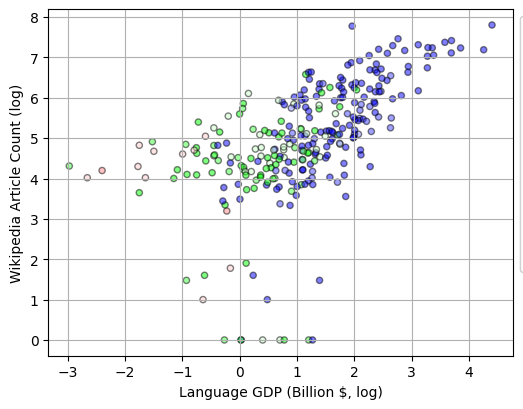

In [154]:
GDPdf=pd.merge(df,GDPdf,on="Name",how="left")

GDPdf=GDPdf[["Name",dependantV,independantV,classN]]

GDPdf=GDPdf.dropna()
GDPdf=GDPdf[GDPdf[independantV]>0]

GDPdf[independantV] =[math.log(s,10) if s!=0 else 0 for s in GDPdf[independantV].tolist()] # Now take log


fileName=independantV+"_vs_"+wk
fileName=fileName.replace(" ","_")
fileName=fileName.replace("$","")
fileName=makeFileNameArxivSafe(fileName)

fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)


scatter = ax.scatter(GDPdf[independantV].tolist(), GDPdf[dependantV].tolist(),s=20,c=GDPdf[classN].tolist(), alpha=0.5,cmap=newcmp, edgecolor='black')
handles = scatter.legend_elements(num=range(len(classes12)))[0]  # Extract the handles from the existing scatter plot

# Produce a legend with the unique colours from the scatter
classes12N=[format12ClassNames(c) for c in classes12]
legend1 = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Classes", handles=handles, labels=classes12N)
ax.add_artist(legend1)

plt.grid()
plt.ylabel("Wikipedia Article Count (log)")
plt.xlabel("Language GDP (Billion $, log)")

plt.savefig(pathI+fileName+'.png',bbox_inches='tight', dpi=500)

In [155]:
lines=GDPdf[[independantV,dependantV]].corr().to_latex()
lines=lines.split("\midrule")[1]
lines=lines.split("\\bottomrule")[0]
lines=lines.split("_x &")[1]
lines=lines.split("&")[0]
lines=lines.strip()
print(lines)

f=open(pathT+"CorrGDP.tex",'w')
f.write(lines)
f.close()

<ipython-input-155-247941823f53>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  lines=GDPdf[[independantV,dependantV]].corr().to_latex()


0.561474


# Generate OPUS Data count table
* Table 7: OPUS Data Set Counts



In [156]:
OPUSlangsC={} # Fix the capitalization issue in OPUS

for l in OPUSlangs:
  OPUSlangsC[l.capitalize()]=OPUSlangs[l]

OPUSlangs=OPUSlangsC

OPUSlangs=pd.DataFrame.from_dict(OPUSlangs, orient='index')

OPUSlangs["Name"]=OPUSlangs.index

OPUSlangs.rename(columns = {0:'OPUSlangs'}, inplace = True)

OPUSlangsData=pd.merge(data,OPUSlangs,on=bl,how="left")

columsToSelct=OPUSlangs.columns.tolist()
columsToSelct=columsToSelct+["ethnolog_Size","ethnolog_Vitality"]

OPUSlangs=OPUSlangsData[columsToSelct]

OPUSlangs=OPUSlangs.dropna(subset=["OPUSlangs"])

OPUSlangs["Class"]=OPUSlangs["ethnolog_Size"]+"-"+OPUSlangs["ethnolog_Vitality"]

OPUSlangs=OPUSlangs.groupby(['Class']).sum()

OPUSlangs.to_latex()

<ipython-input-156-c332e8a72063>:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OPUSlangs=OPUSlangs.groupby(['Class']).sum()
<ipython-input-156-c332e8a72063>:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  OPUSlangs.to_latex()


'\\begin{tabular}{lr}\n\\toprule\n{} &     OPUSlangs \\\\\nClass               &               \\\\\n\\midrule\nLarge-Institutional &  1.556114e+10 \\\\\nLarge-Stable        &  3.216824e+07 \\\\\nMid-Endangered      &  7.833096e+06 \\\\\nMid-Institutional   &  6.123440e+07 \\\\\nMid-Stable          &  4.243600e+04 \\\\\nSmall-Endangered    &  1.278468e+06 \\\\\nSmall-Extinct       &  8.000000e+00 \\\\\nSmall-Institutional &  1.104000e+03 \\\\\nSmall-Stable        &  1.200500e+04 \\\\\n\\bottomrule\n\\end{tabular}\n'